In [1]:
Sys.setenv(RETICULATE_PYTHON = "/home/gonglihao/miniconda3/envs/42/bin/python")
suppressPackageStartupMessages({
    library("dplyr")
    library("Matrix")
    library("Seurat")
    library("SeuratWrappers")
    library("tictoc")
    library("ggplot2")
    library("ggpubr")
    library("future")
    library("SingleR")
    library("pheatmap")
})

In [2]:
tic()
load("/data3/Group8/gonglihao/1-MMP9/1-QC/shmmp9-1.rda")
toc()

16.403 sec elapsed


In [3]:
tic()
ref <- celldex::ImmGenData()
mat <- GetAssayData(seu, layer="data")
pred.immgen.fine <- SingleR(test = mat, ref = ref, labels = ref$label.fine)
pred.immgen.main <- SingleR(test = mat, ref = ref, labels = ref$label.main)

seu[["pred.immgen.fine"]]      <-pred.immgen.fine$labels
seu[["pred.immgen.finepruned"]]<-pred.immgen.fine$pruned.labels

seu[["pred.immgen.main"]]      <-pred.immgen.main$labels
seu[["pred.immgen.mainpruned"]]<-pred.immgen.main$pruned.labels
toc()

291.442 sec elapsed


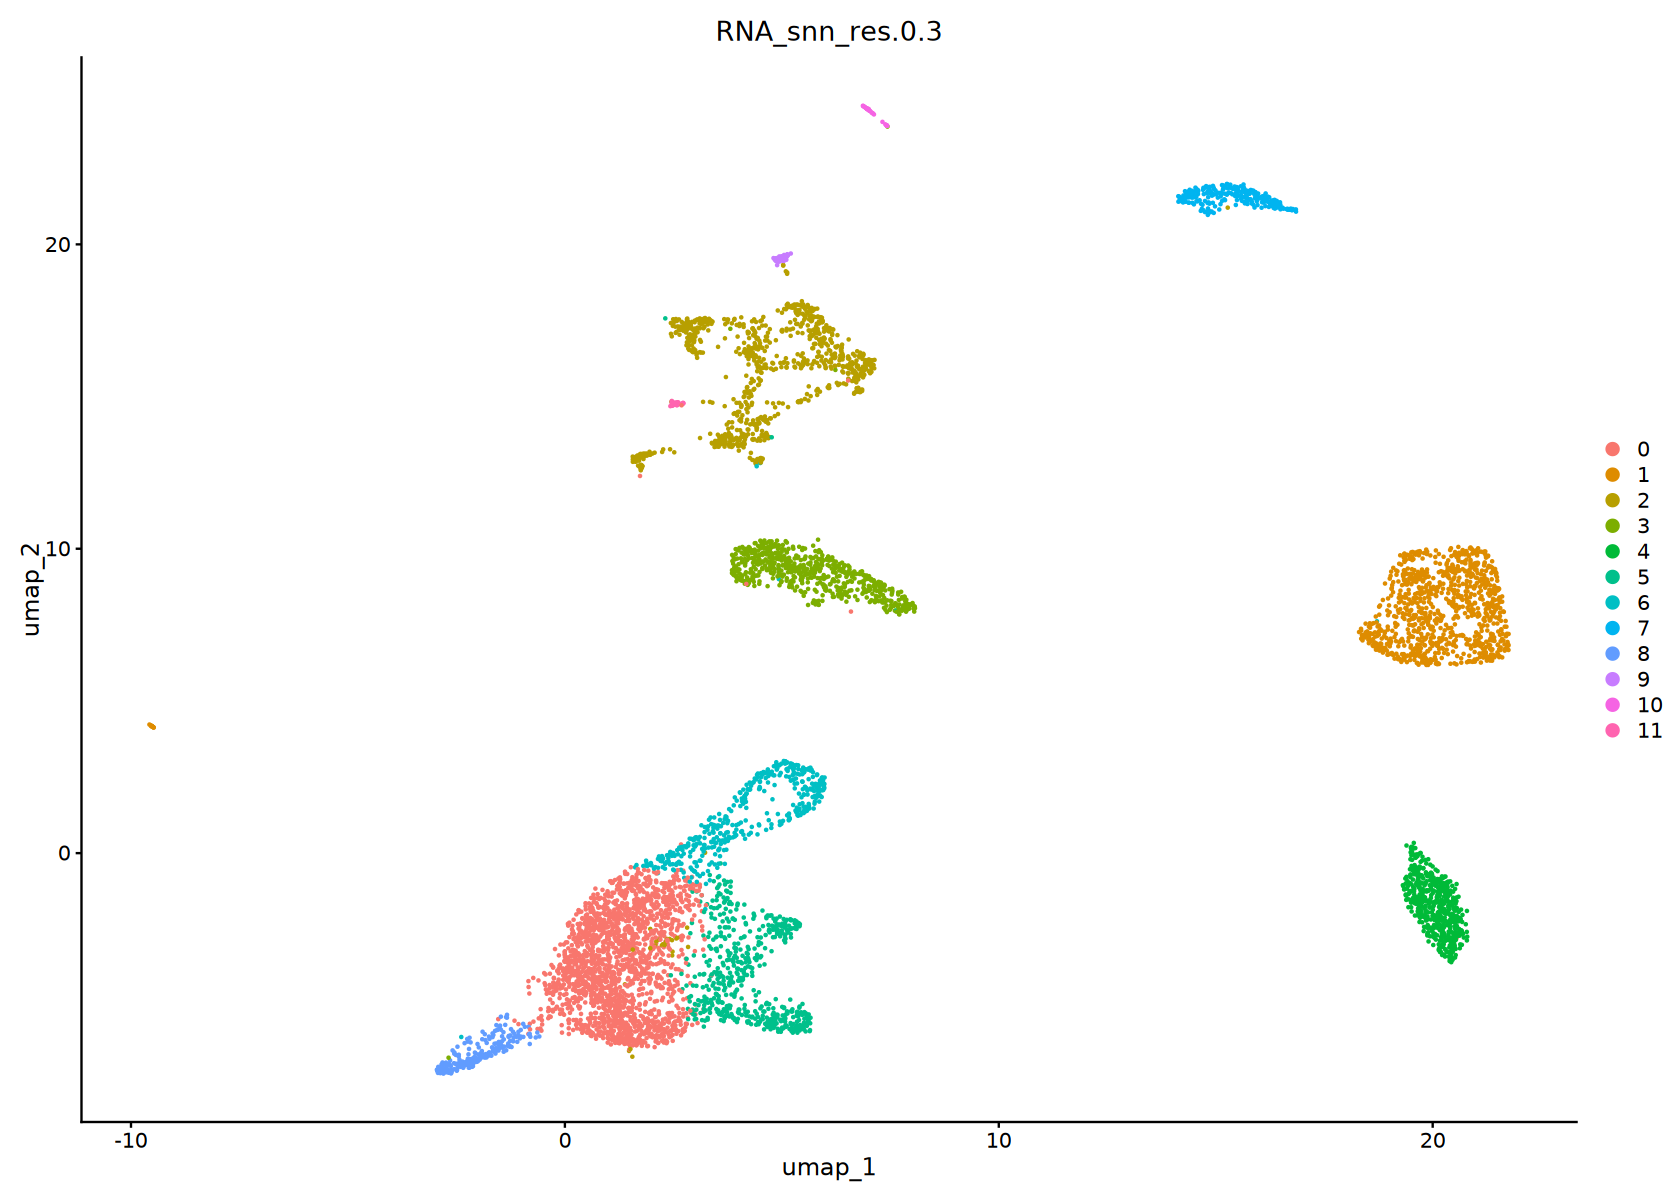

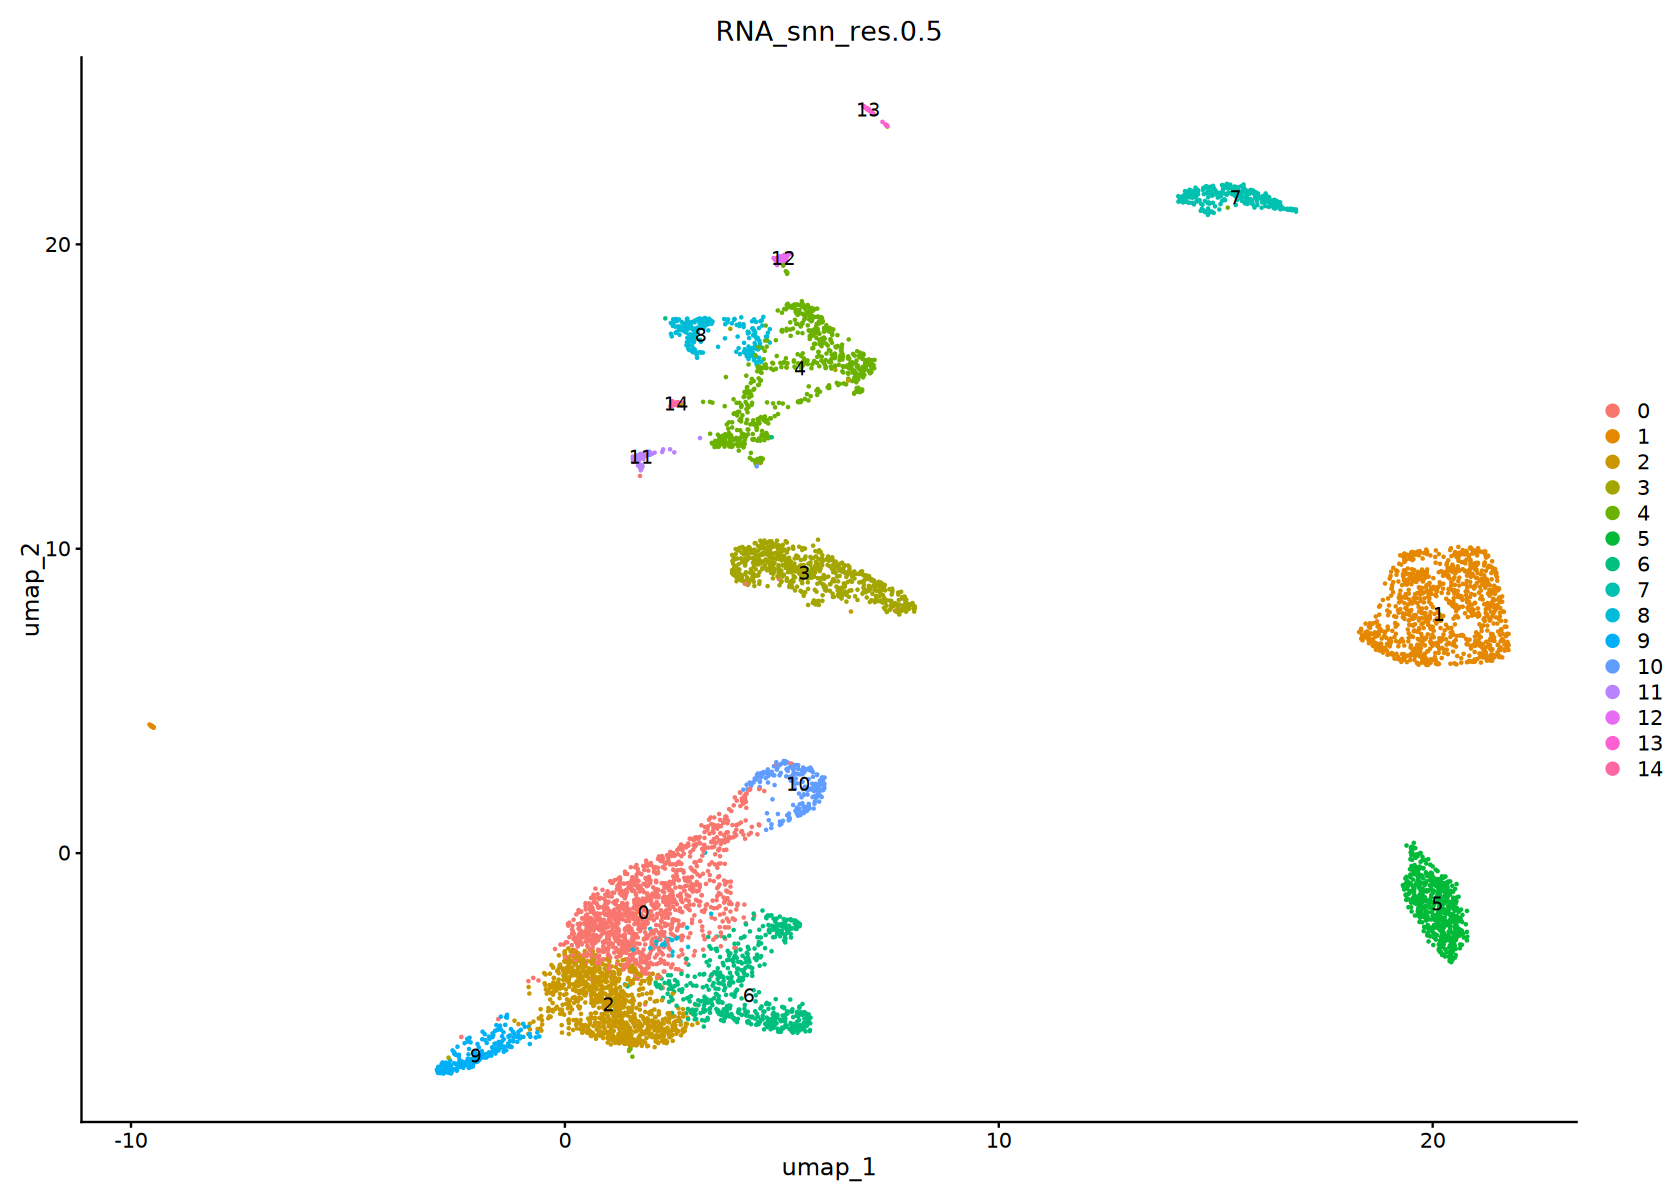

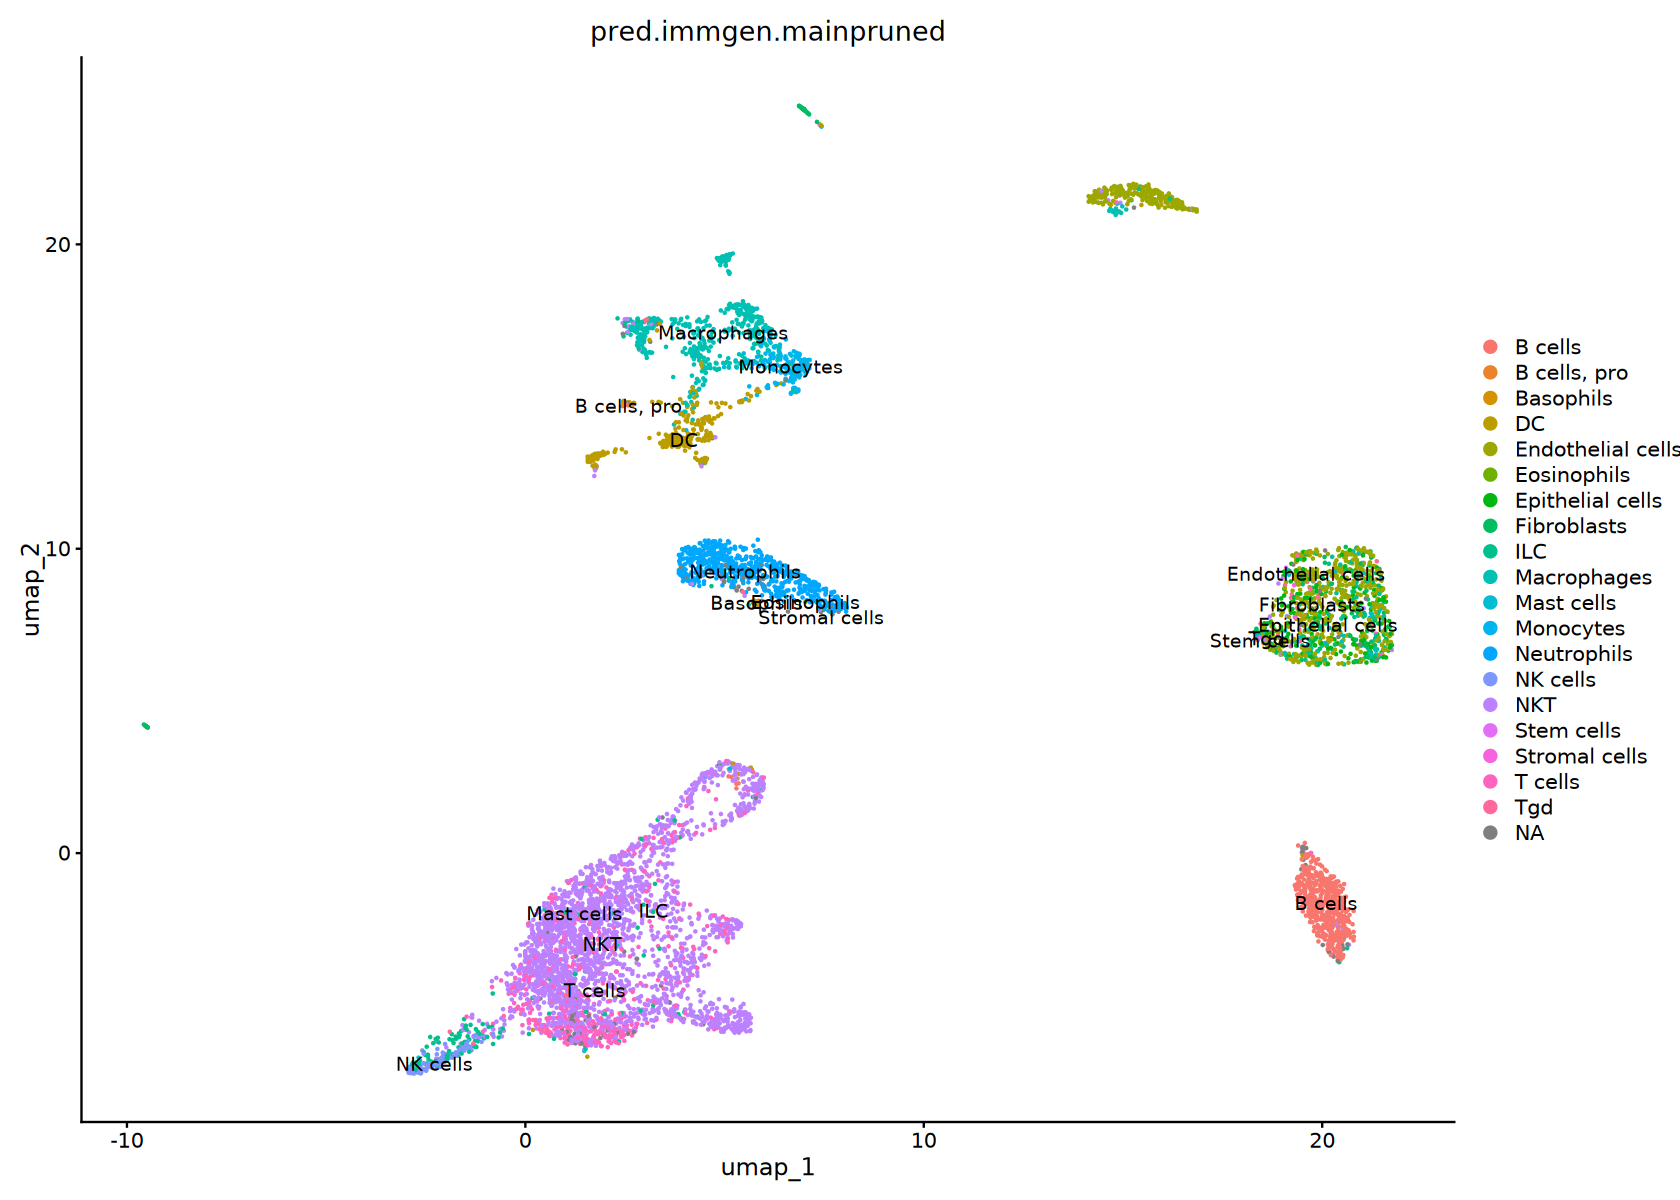

In [4]:
options(repr.plot.width=14, repr.plot.height=10)
DimPlot(seu, group.by="RNA_snn_res.0.3")
DimPlot(seu, group.by="RNA_snn_res.0.5", label=T)
DimPlot(seu, group.by="pred.immgen.mainpruned", label=T)

In [5]:
seu->seu.all

# note that cell clusters that are of interests under RNA_snn_res.0.5
# c(0,2,4,6,8,10,11)

In [6]:
Idents(seu)<-"RNA_snn_res.0.5"
tic("DE")
markers <- FindAllMarkers(seu, only.pos = FALSE, min.pct = 0.25, 
                          logfc.threshold = 0.25, return.thresh = 0.01)
toc()

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



DE: 56.663 sec elapsed


In [7]:
# Filter
markers <- markers[ markers$p_val_adj<0.01, ]
# Sort
markers <- markers[ order(markers$cluster, -markers$avg_log2FC), ]

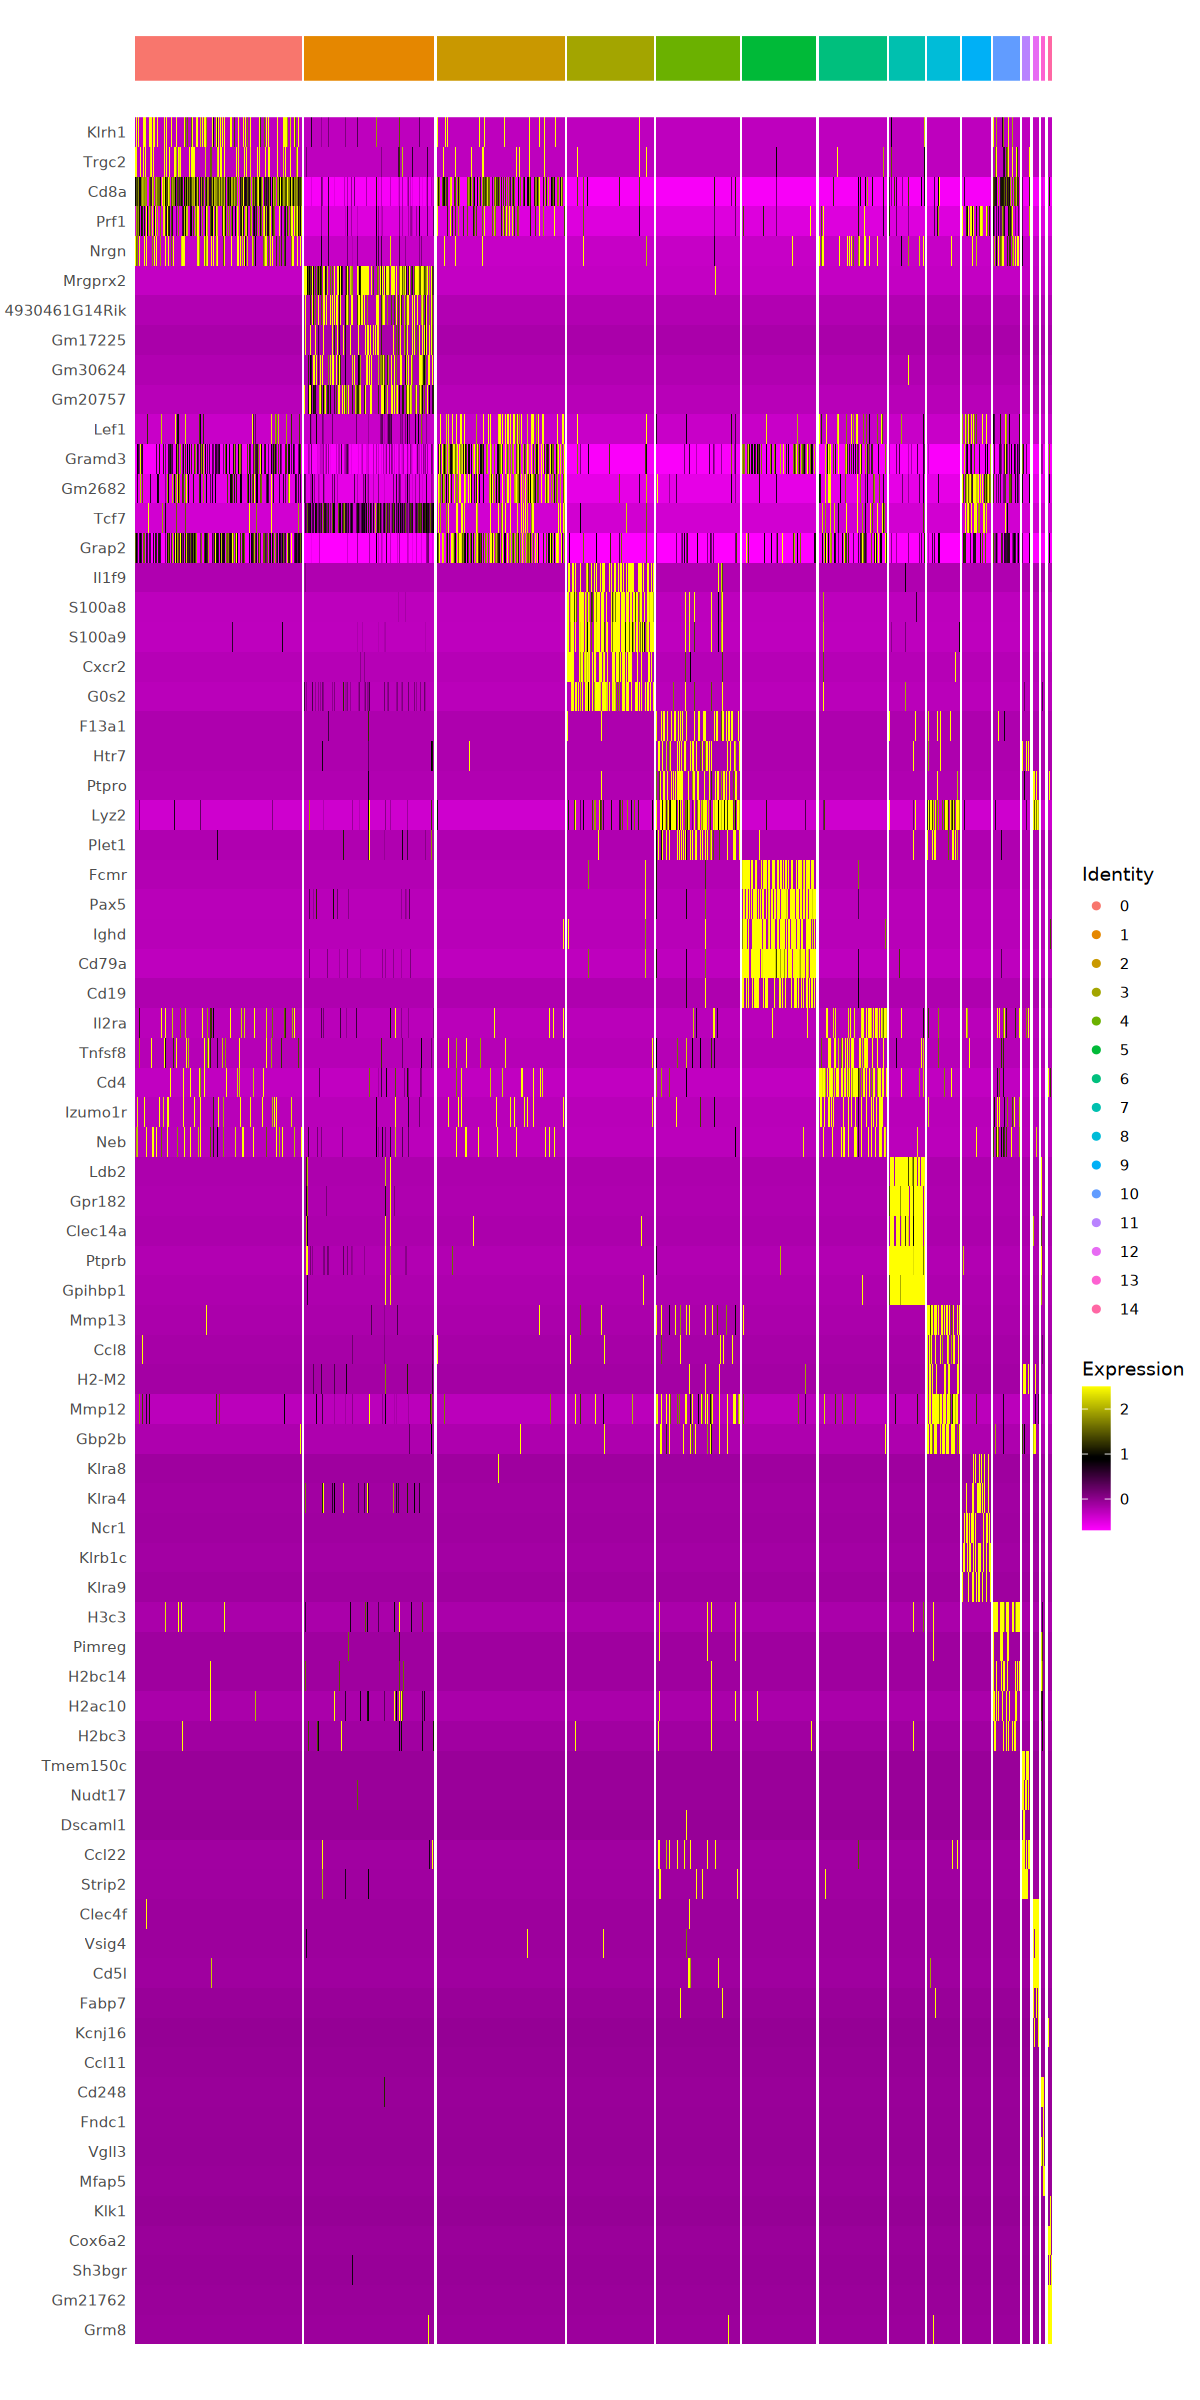

In [8]:
seu$RNA_snn_res.0.5 <- factor(seu$RNA_snn_res.0.5, 
                             levels = sort(as.numeric(as.character(unique(seu$RNA_snn_res.0.5)))))
Idents(seu) <- seu$RNA_snn_res.0.5

# 然后处理markers数据框
markers$cluster <- factor(markers$cluster, 
                         levels = sort(as.numeric(as.character(unique(markers$cluster)))))

# 获取top基因
markers.top <- markers %>%
    group_by(cluster) %>%
    top_n(n = 5, wt = avg_log2FC)

# 绘制热图
options(repr.plot.width=10, repr.plot.height=20)
DoHeatmap(seu, features = markers.top$gene, label=F)

In [9]:
seu0<-subset(seu, RNA_snn_res.0.5==0)
markers.top[markers.top$cluster==0, ]

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene 
1 3.312815e-214 3.842581   0.326 0.044 1.035354e-209 0       Klrh1
2 2.474944e-145 2.816241   0.281 0.050 7.734944e-141 0       Trgc2
3  0.000000e+00 2.541609   0.894 0.217  0.000000e+00 0       Cd8a 
4 1.208864e-282 2.478518   0.609 0.148 3.778062e-278 0       Prf1 
5 5.332729e-146 2.451258   0.340 0.078 1.666638e-141 0       Nrgn

In [10]:
cluster_names <- unique(sort(seu@meta.data$"RNA_snn_res.0.5"))
seu_subsets <-list()
for (cluster in cluster_names){
    cluster<-as.character(cluster)
    seu_subsets[[cluster]]<-subset(seu, RNA_snn_res.0.5==cluster)
}

putative_doublets<-c()

#C1

In [11]:
seu <- seu_subsets[["1"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multicore", workers = 54)
options(future.globals.maxSize = Inf)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["1"]]

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 50.78 sec elapsed


Computing nearest neighbor graph

Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only



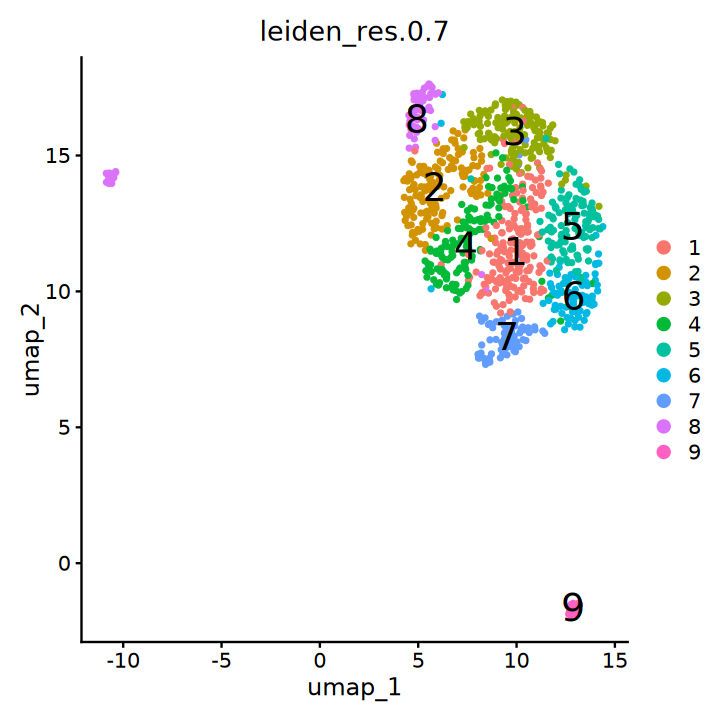

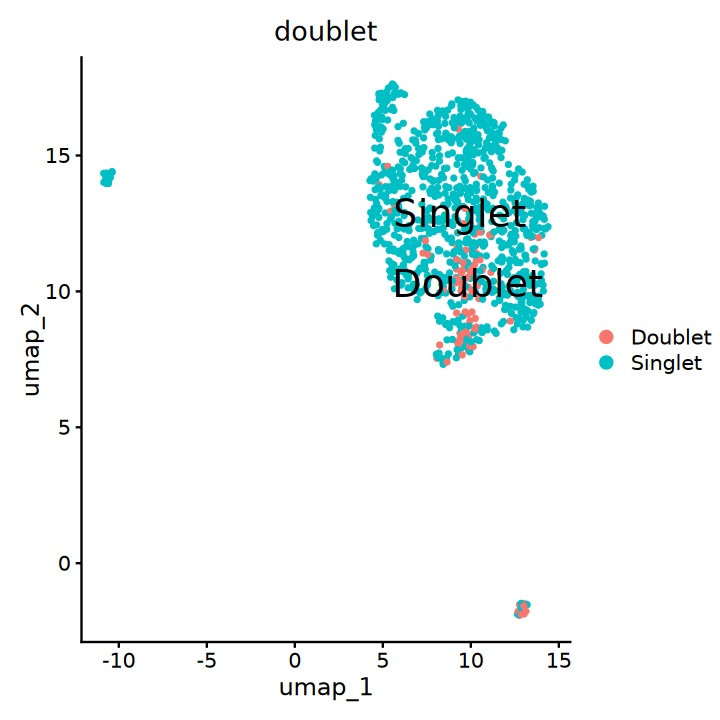

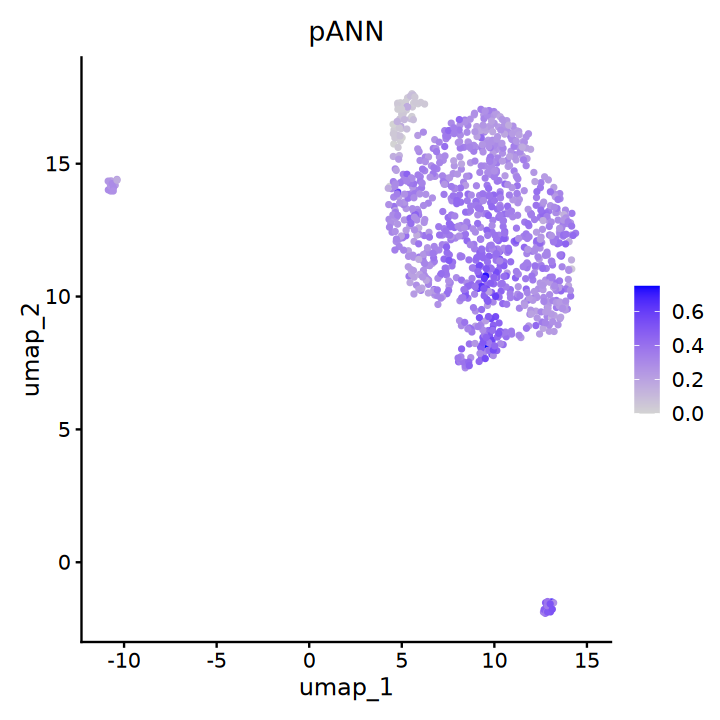

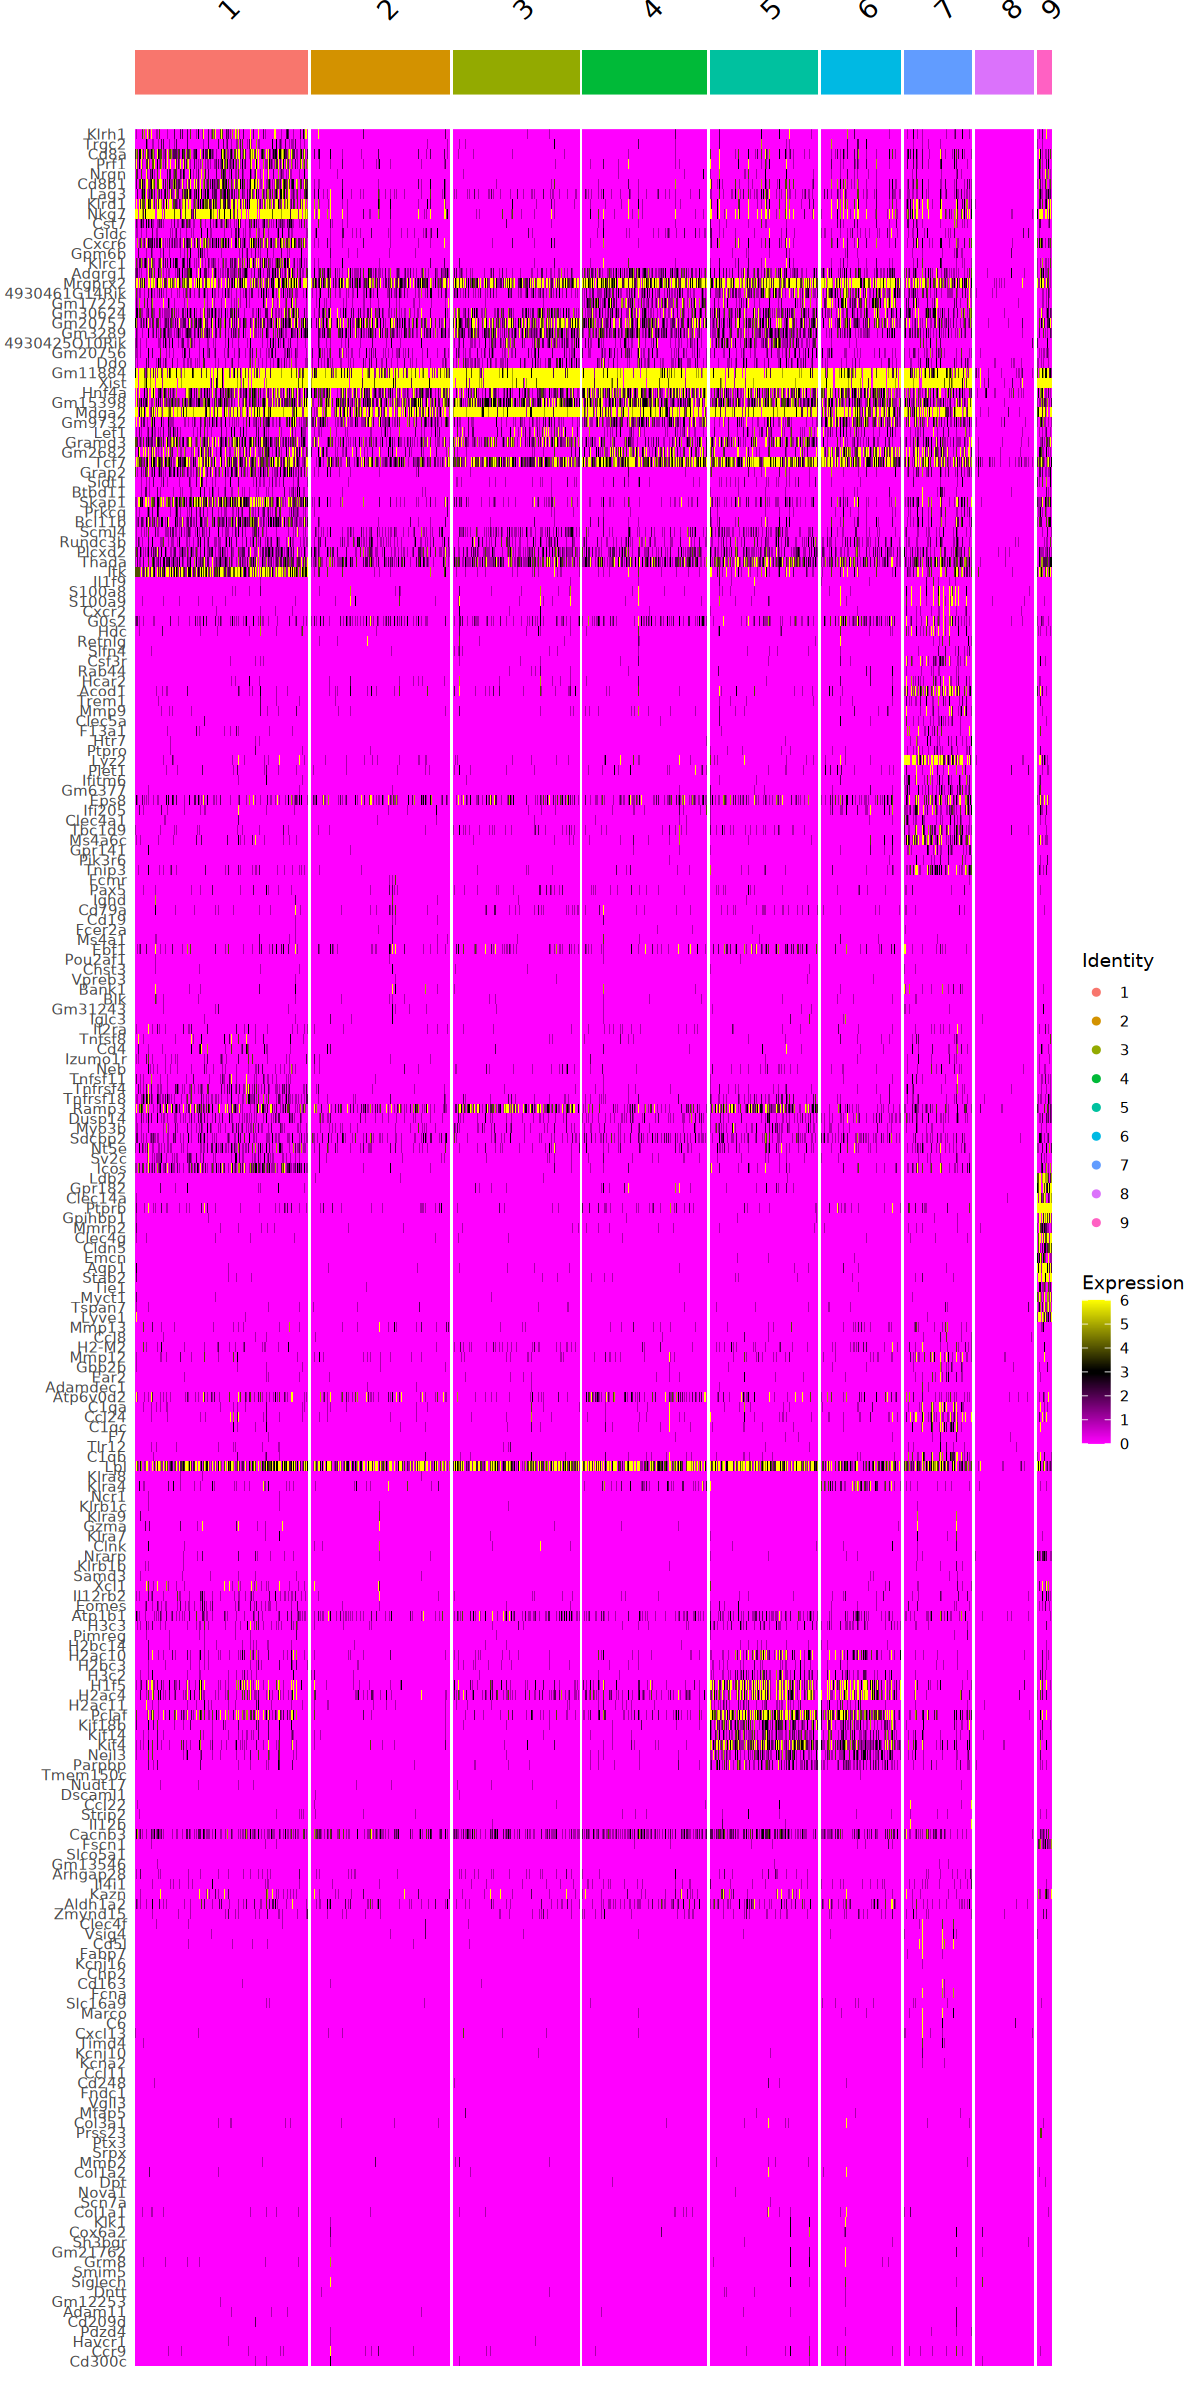

In [12]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")

# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_log2FC)
options(repr.plot.width=10, repr.plot.height=20)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [13]:
barcodes<-colnames(subset(seu, leiden_res.0.7=="1"|leiden_res.0.7=="7"|leiden_res.0.7=="8"|leiden_res.0.7=="9"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

#C5

In [14]:
seu <- seu_subsets[["5"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multicore", workers = 54)
options(future.globals.maxSize = Inf)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["5"]]

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 24.683 sec elapsed


Computing nearest neighbor graph

Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only



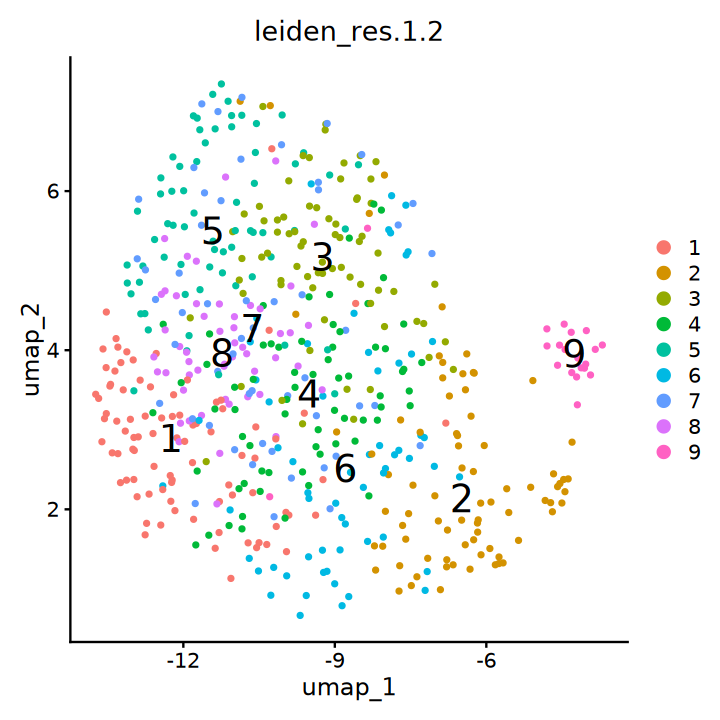

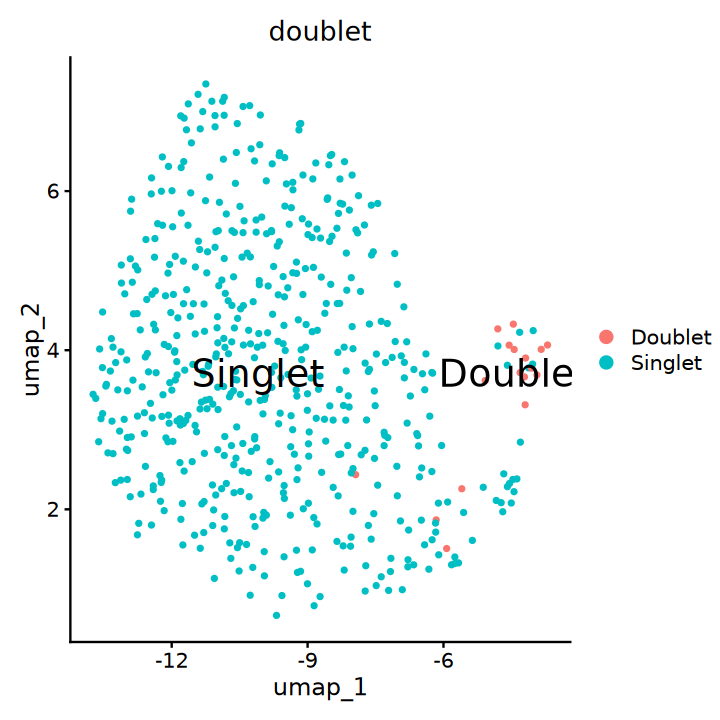

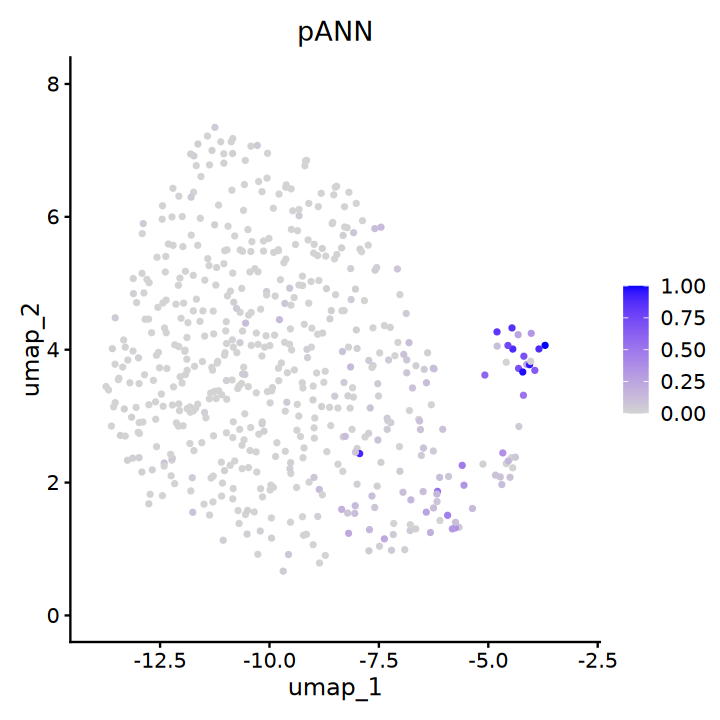

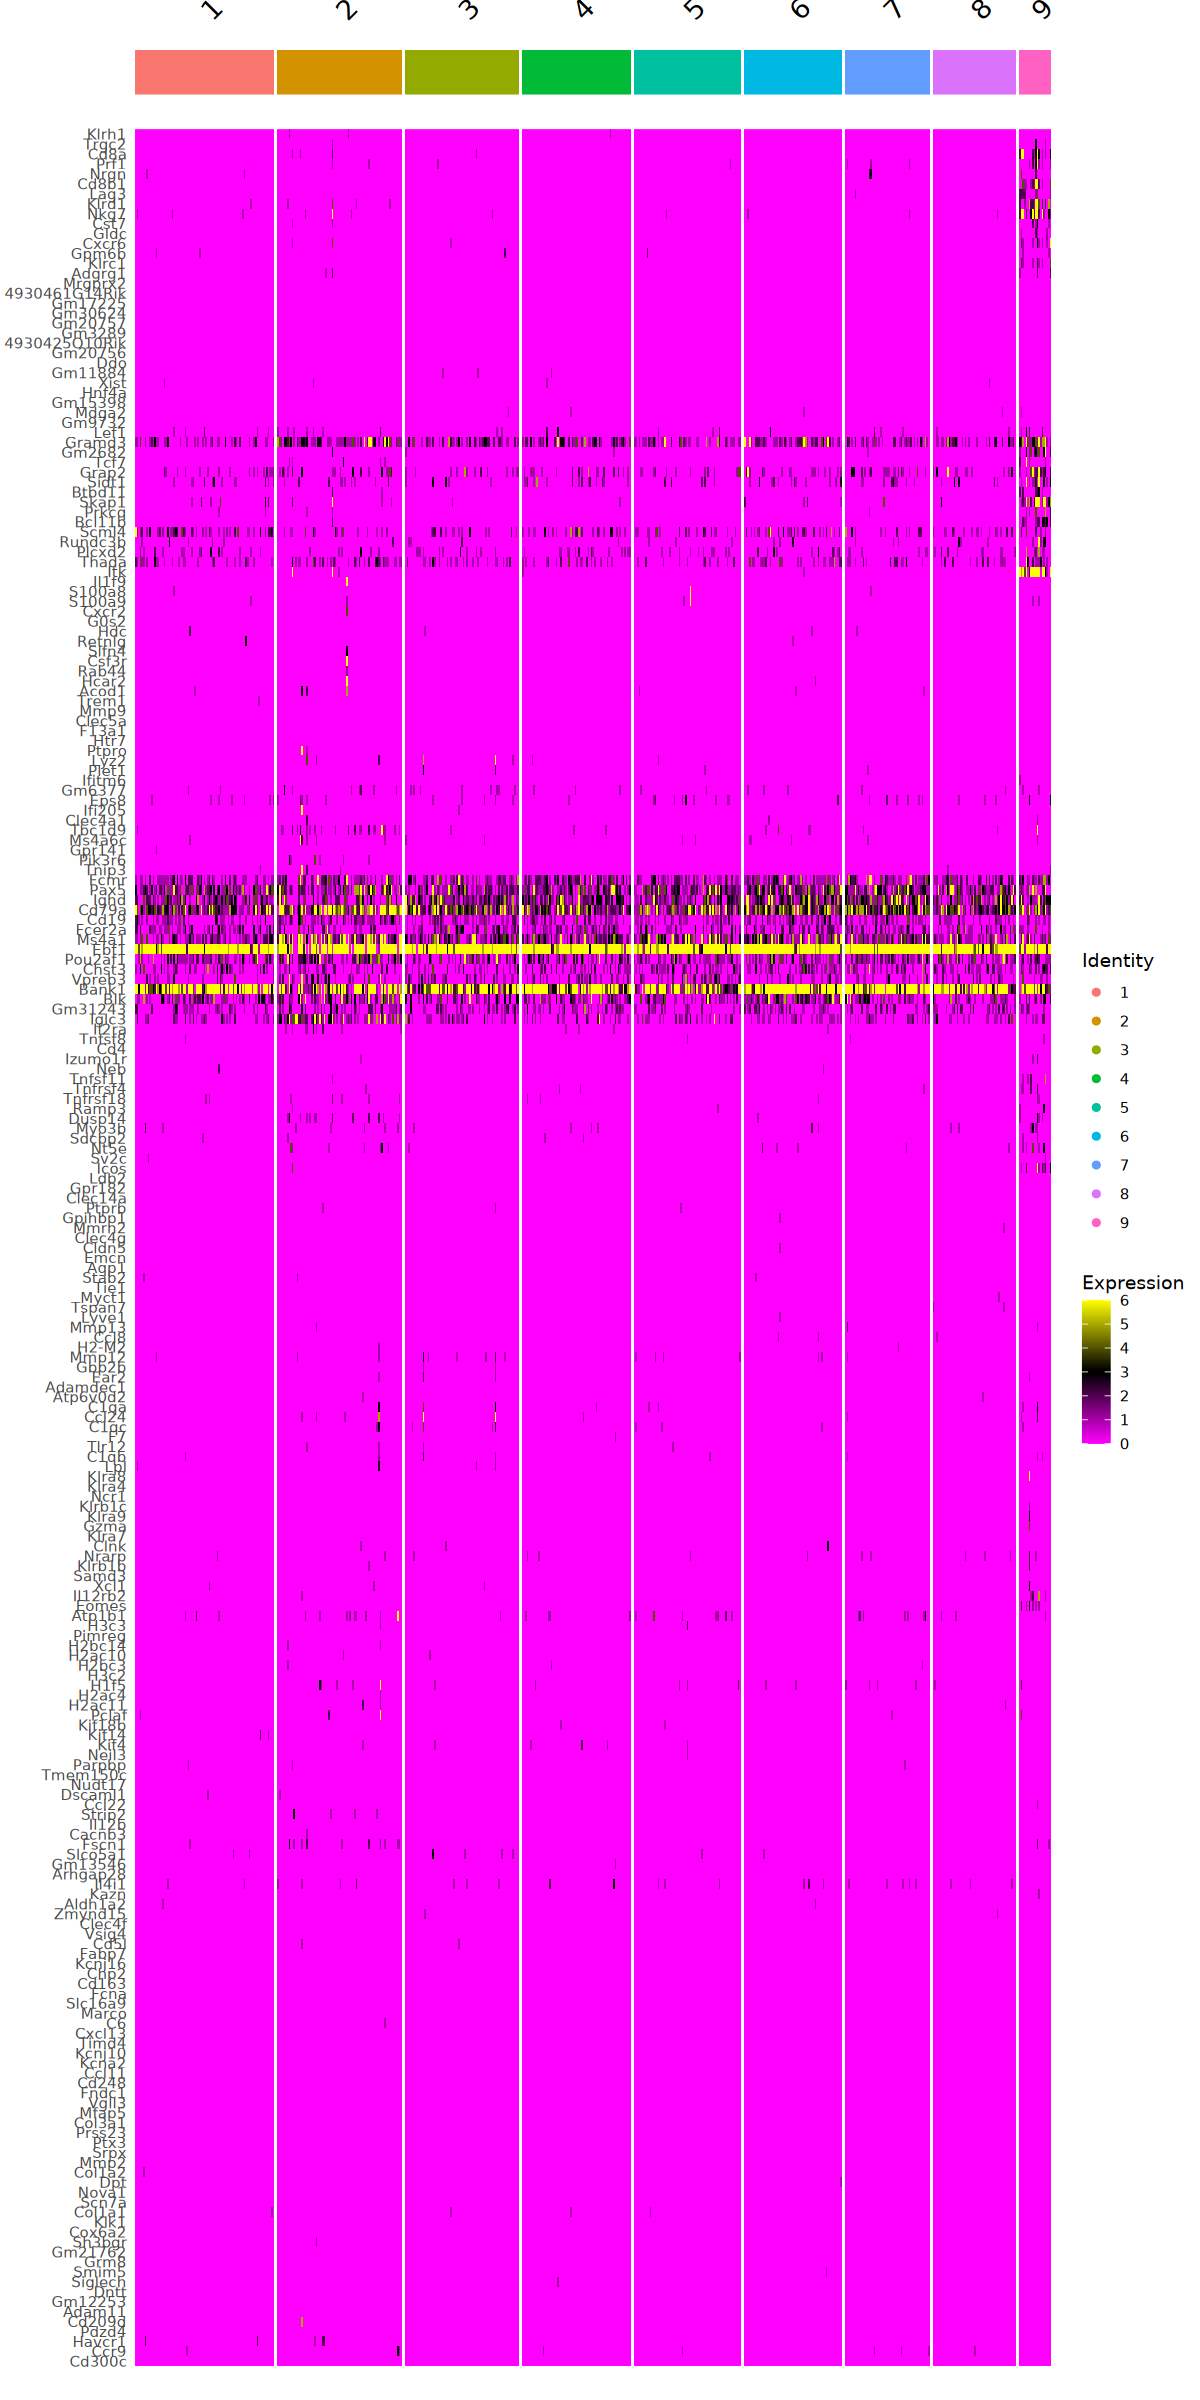

In [15]:
grp="leiden_res.1.2"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")

# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_log2FC)
options(repr.plot.width=10, repr.plot.height=20)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [16]:
barcodes<-colnames(subset(seu, leiden_res.1.2=="9"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

#C3

In [17]:
seu <- seu_subsets[["3"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multicore", workers = 54)
options(future.globals.maxSize = Inf)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["3"]]

Normalizing layer: counts

Finding variable features for layer counts

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -2.5139”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.0379e-16”
Centering and scaling data matrix



Renormalization and Dimensionality reduction: 23.824 sec elapsed


Computing nearest neighbor graph

Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only



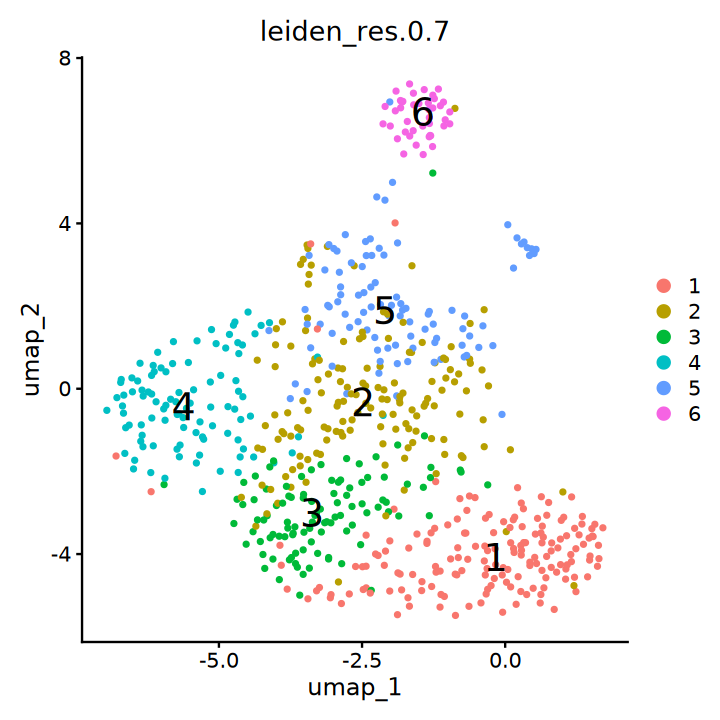

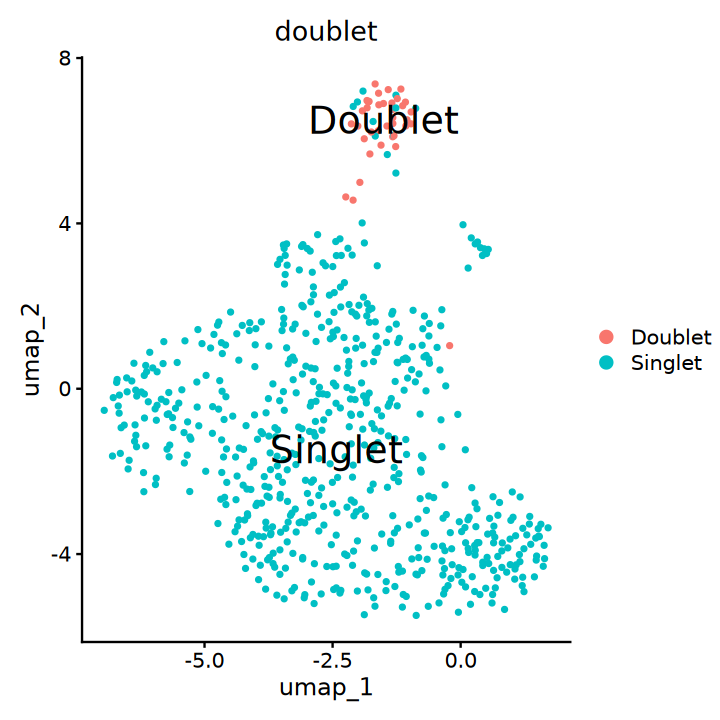

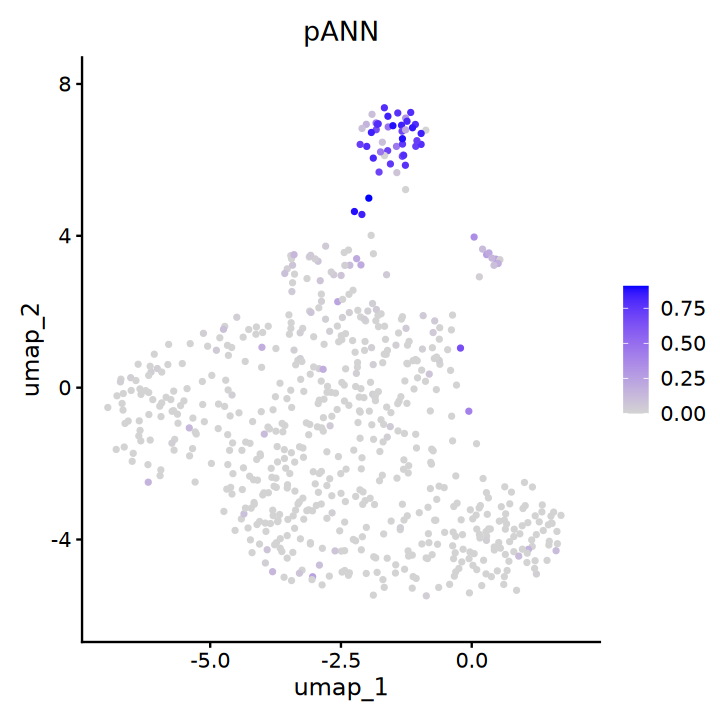

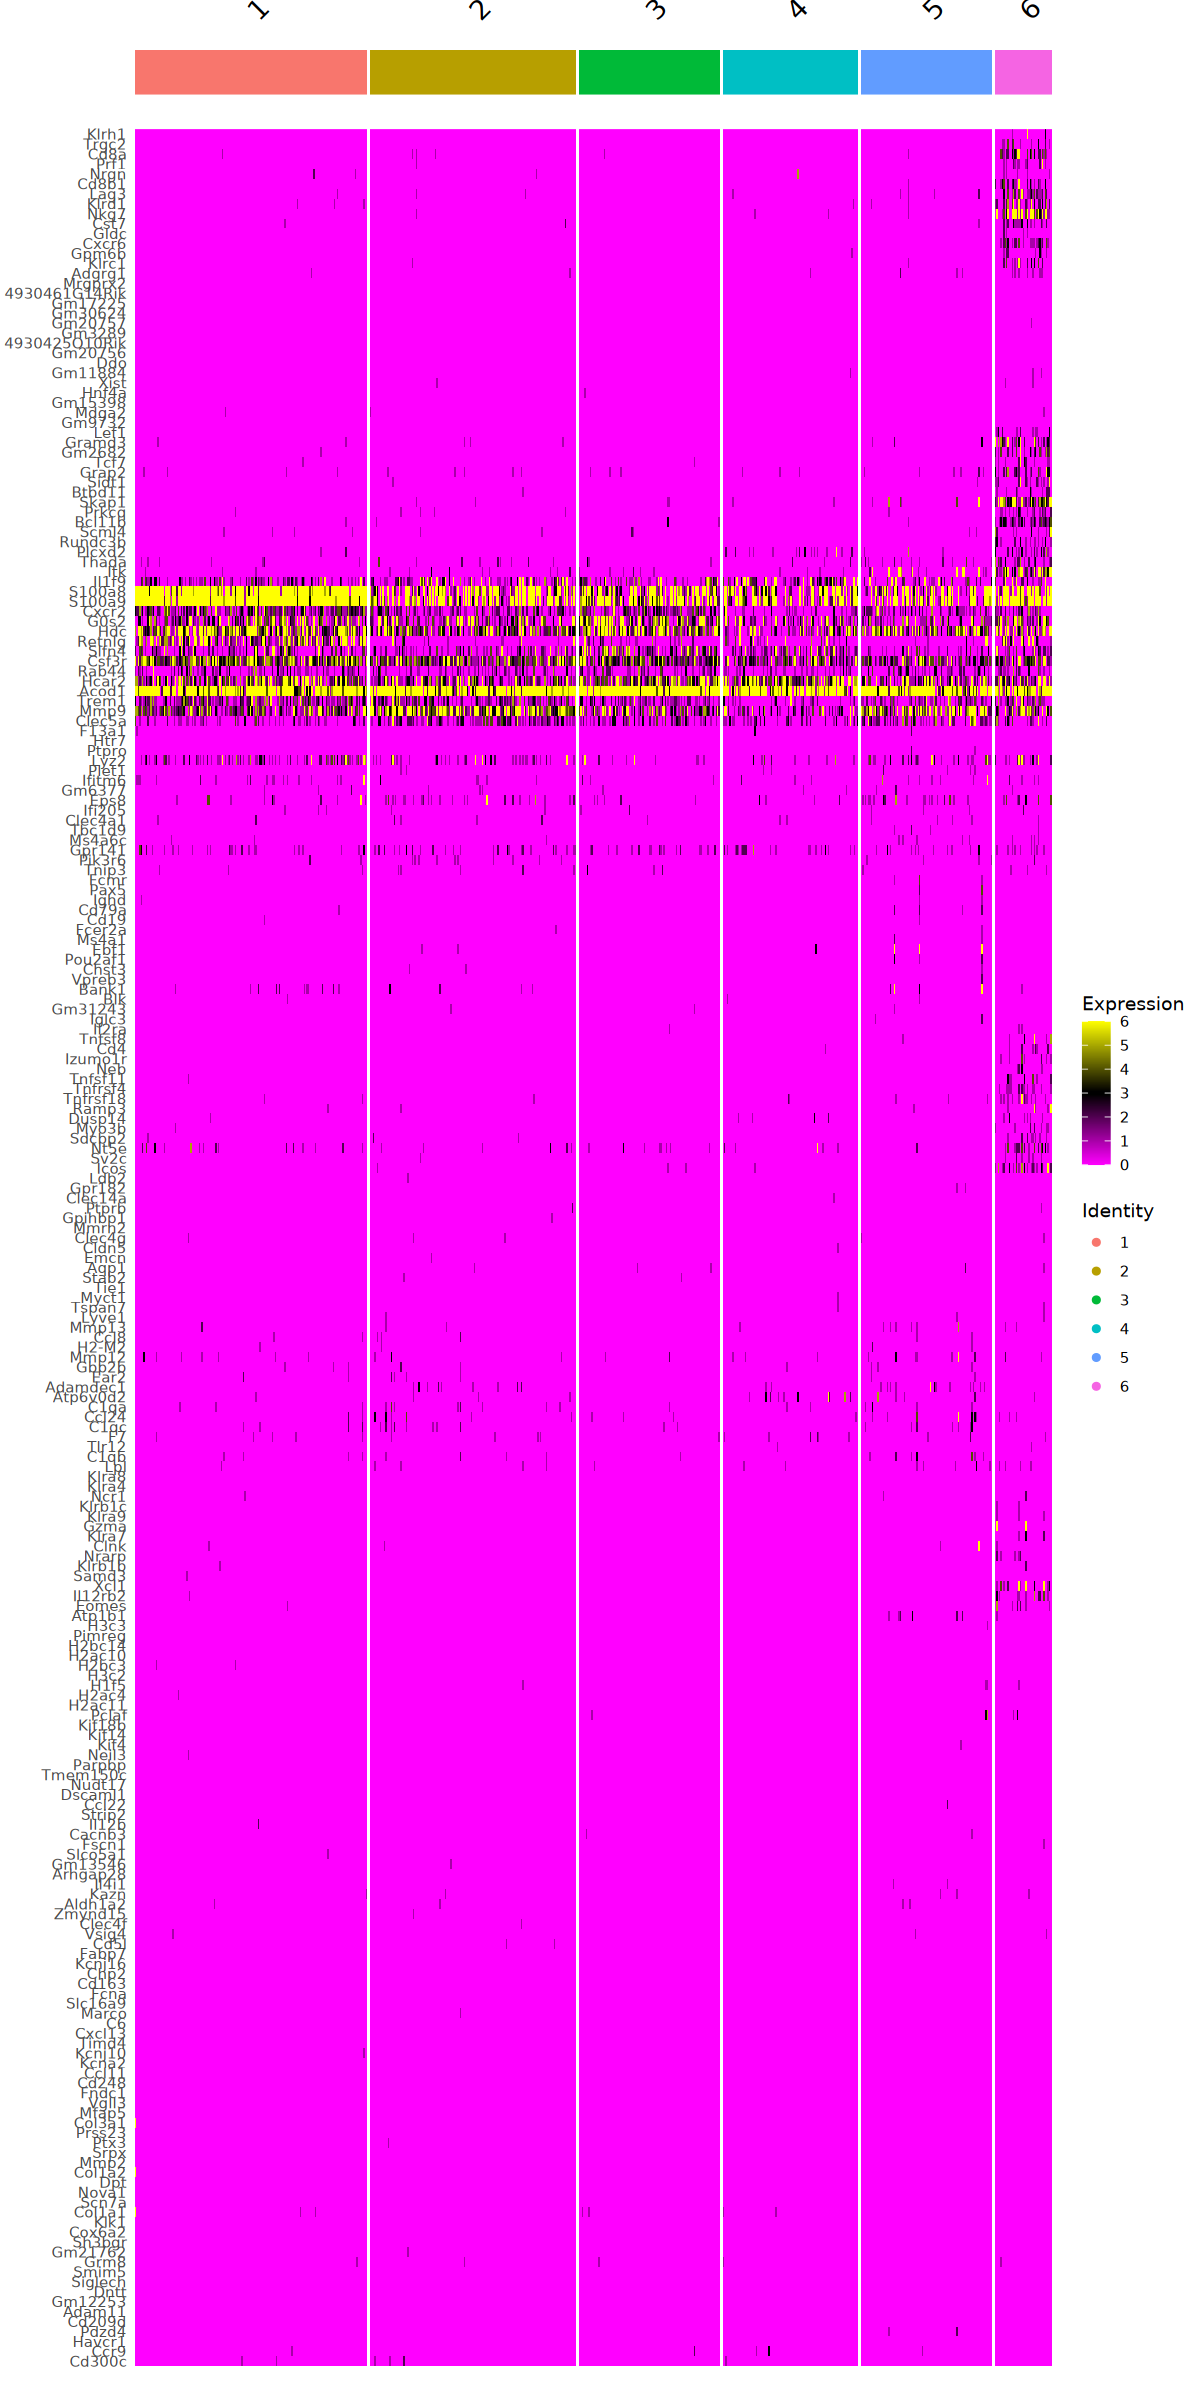

In [18]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")

# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_log2FC)
options(repr.plot.width=10, repr.plot.height=20)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [19]:
barcodes<-colnames(subset(seu, leiden_res.0.7=="6"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C0

In [20]:
seu <- seu_subsets[["0"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multicore", workers = 54)
options(future.globals.maxSize = Inf)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["0"]]

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 32.611 sec elapsed


Computing nearest neighbor graph

Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only



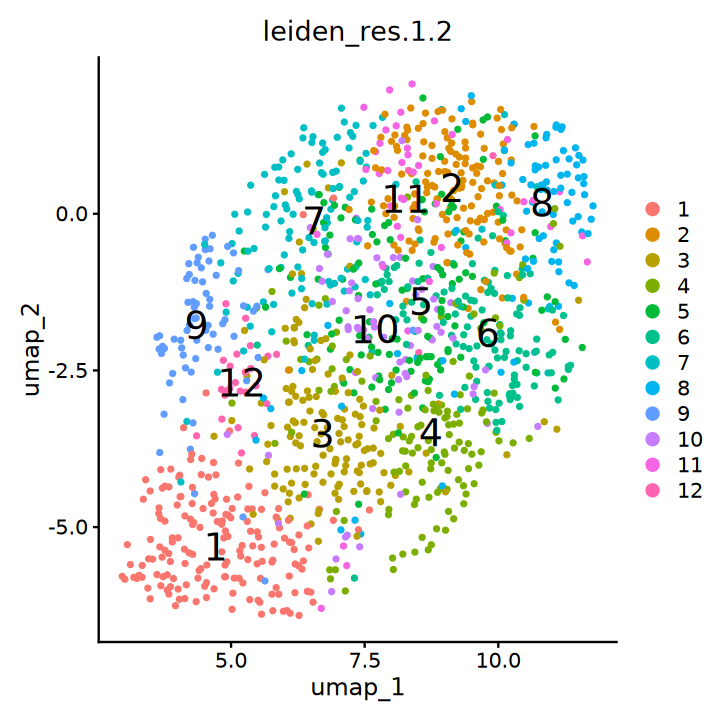

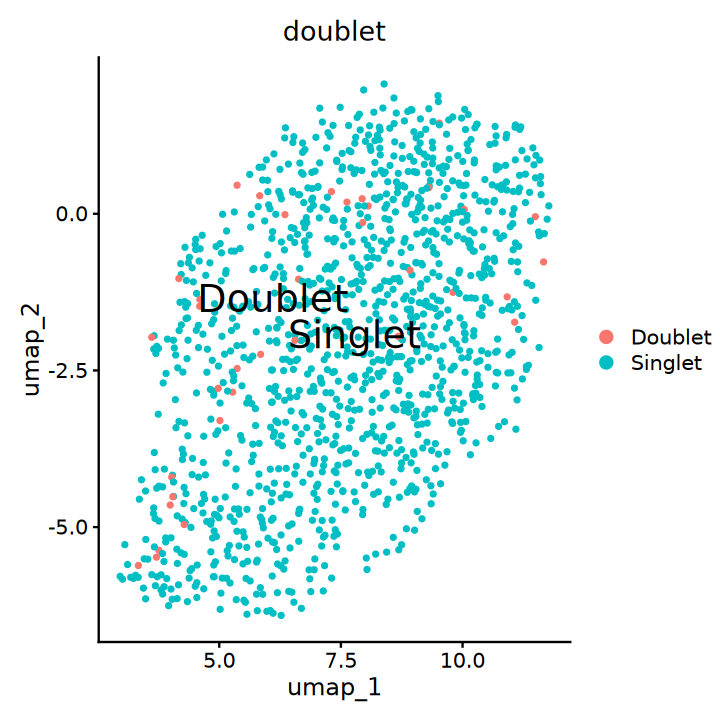

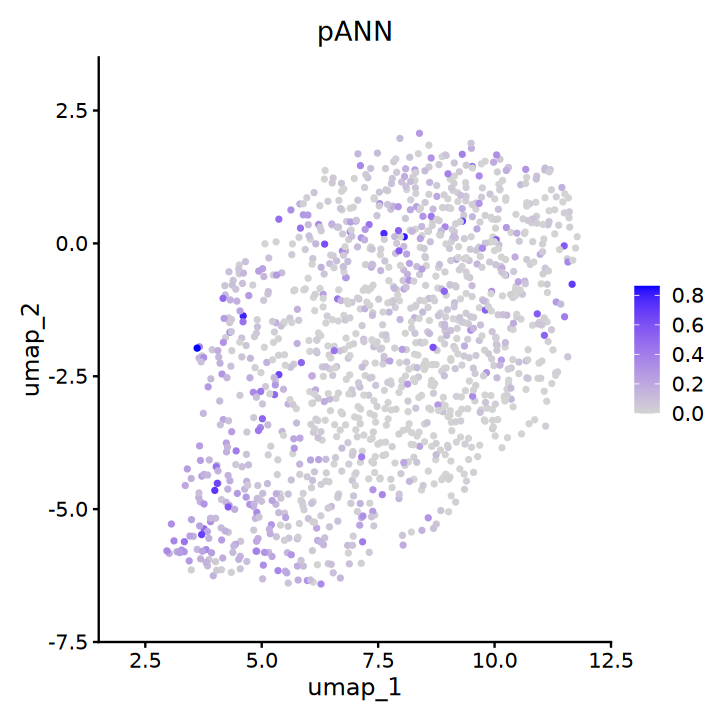

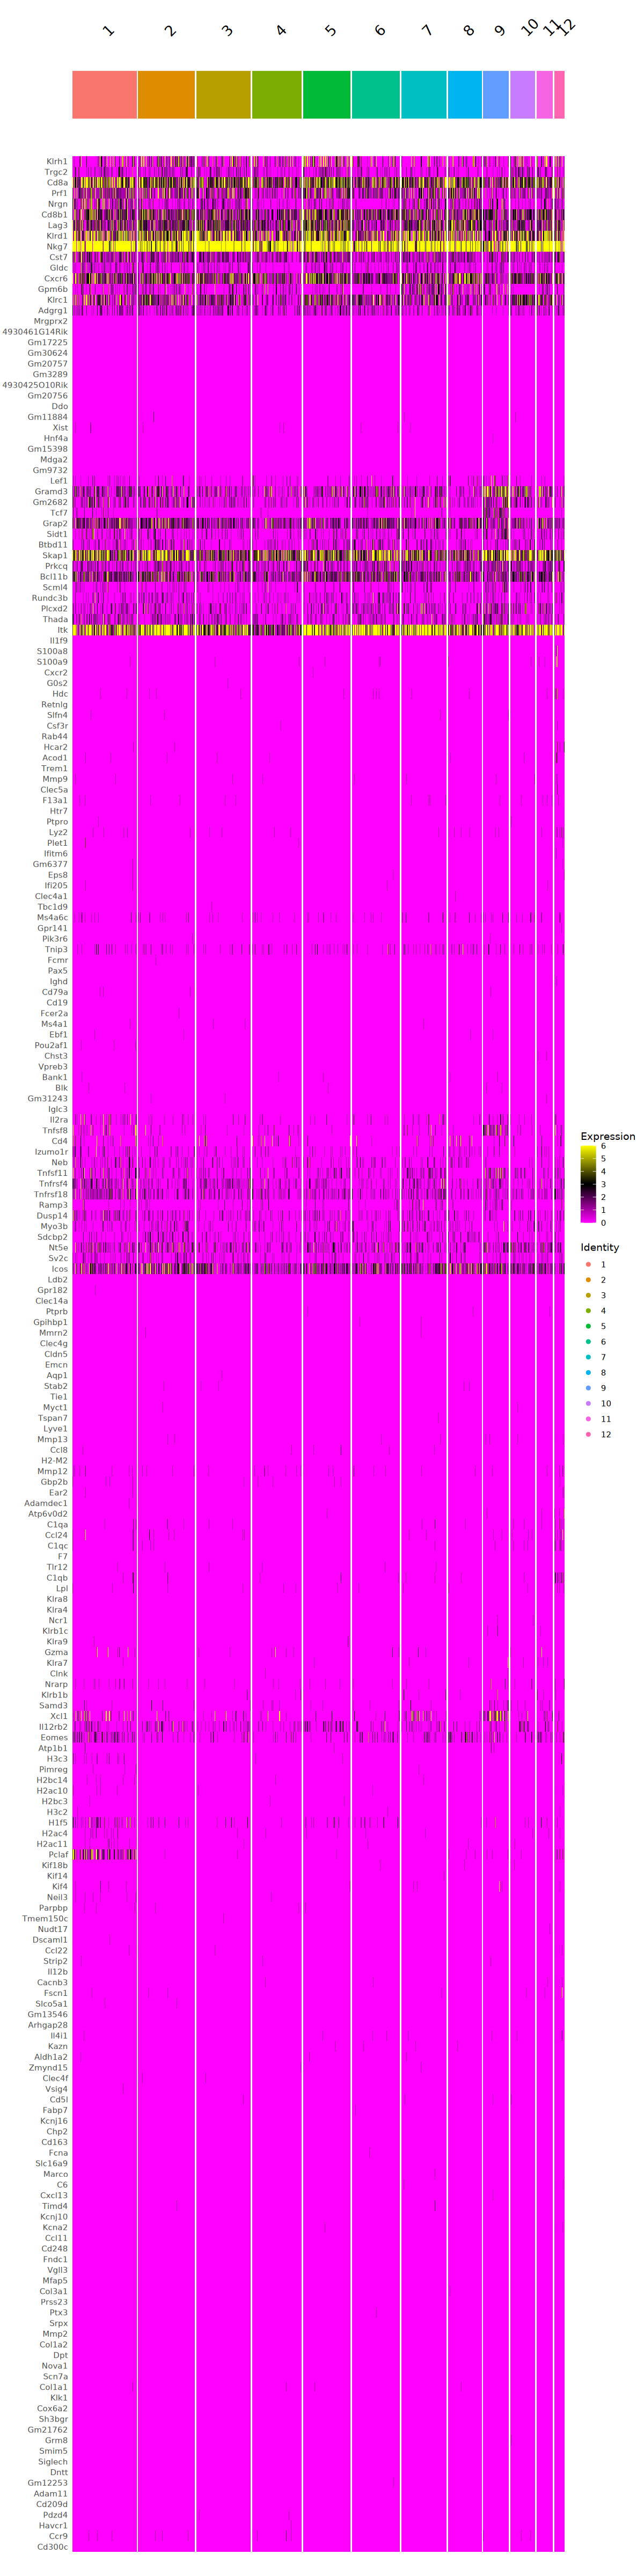

In [21]:
grp="leiden_res.1.2"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_log2FC)
options(repr.plot.width=10, repr.plot.height=40)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [22]:
barcodes<-colnames(subset(seu, doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C2

In [23]:
seu <- seu_subsets[["2"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multicore", workers = 54)
options(future.globals.maxSize = Inf)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["2"]]

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 34.866 sec elapsed


Computing nearest neighbor graph

Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only



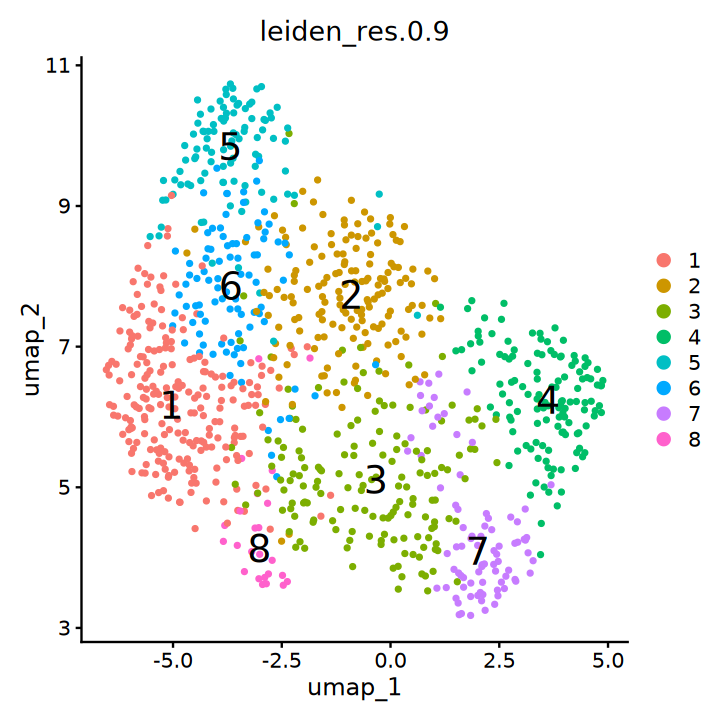

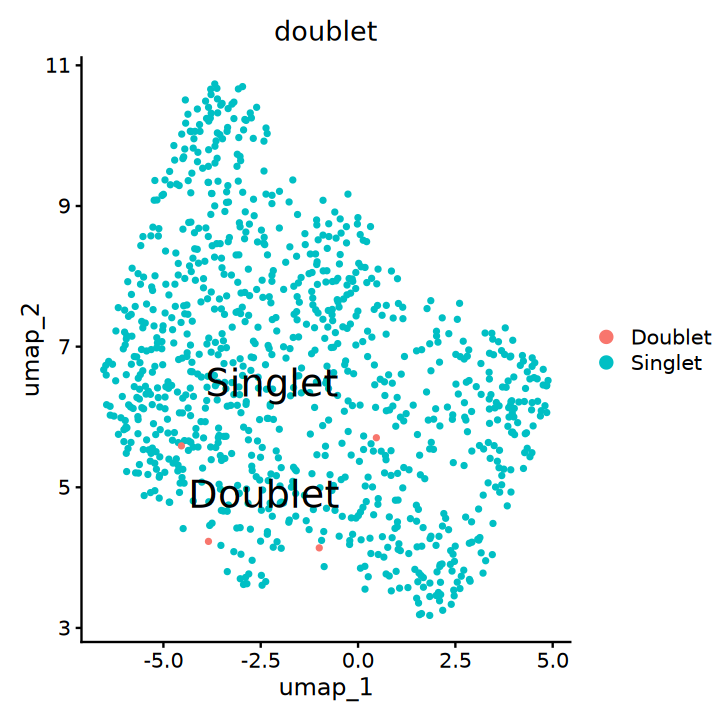

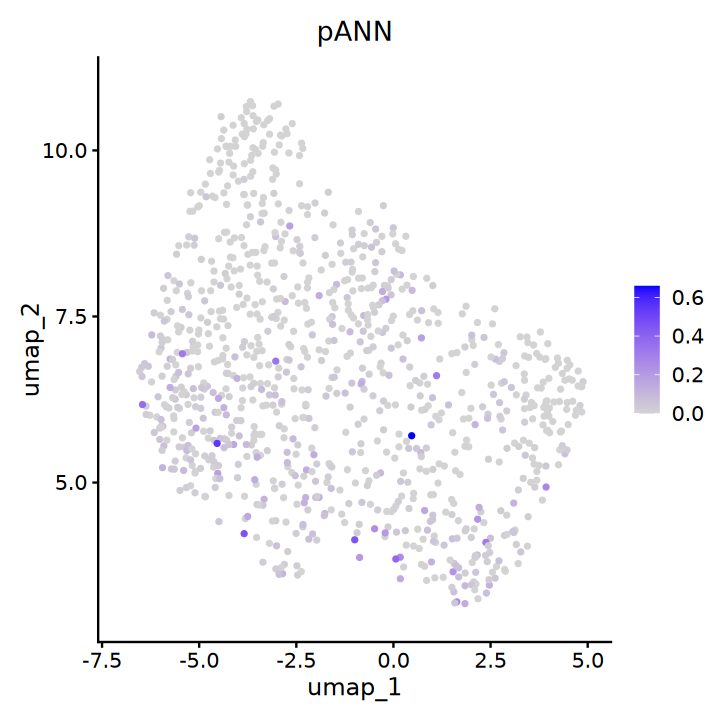

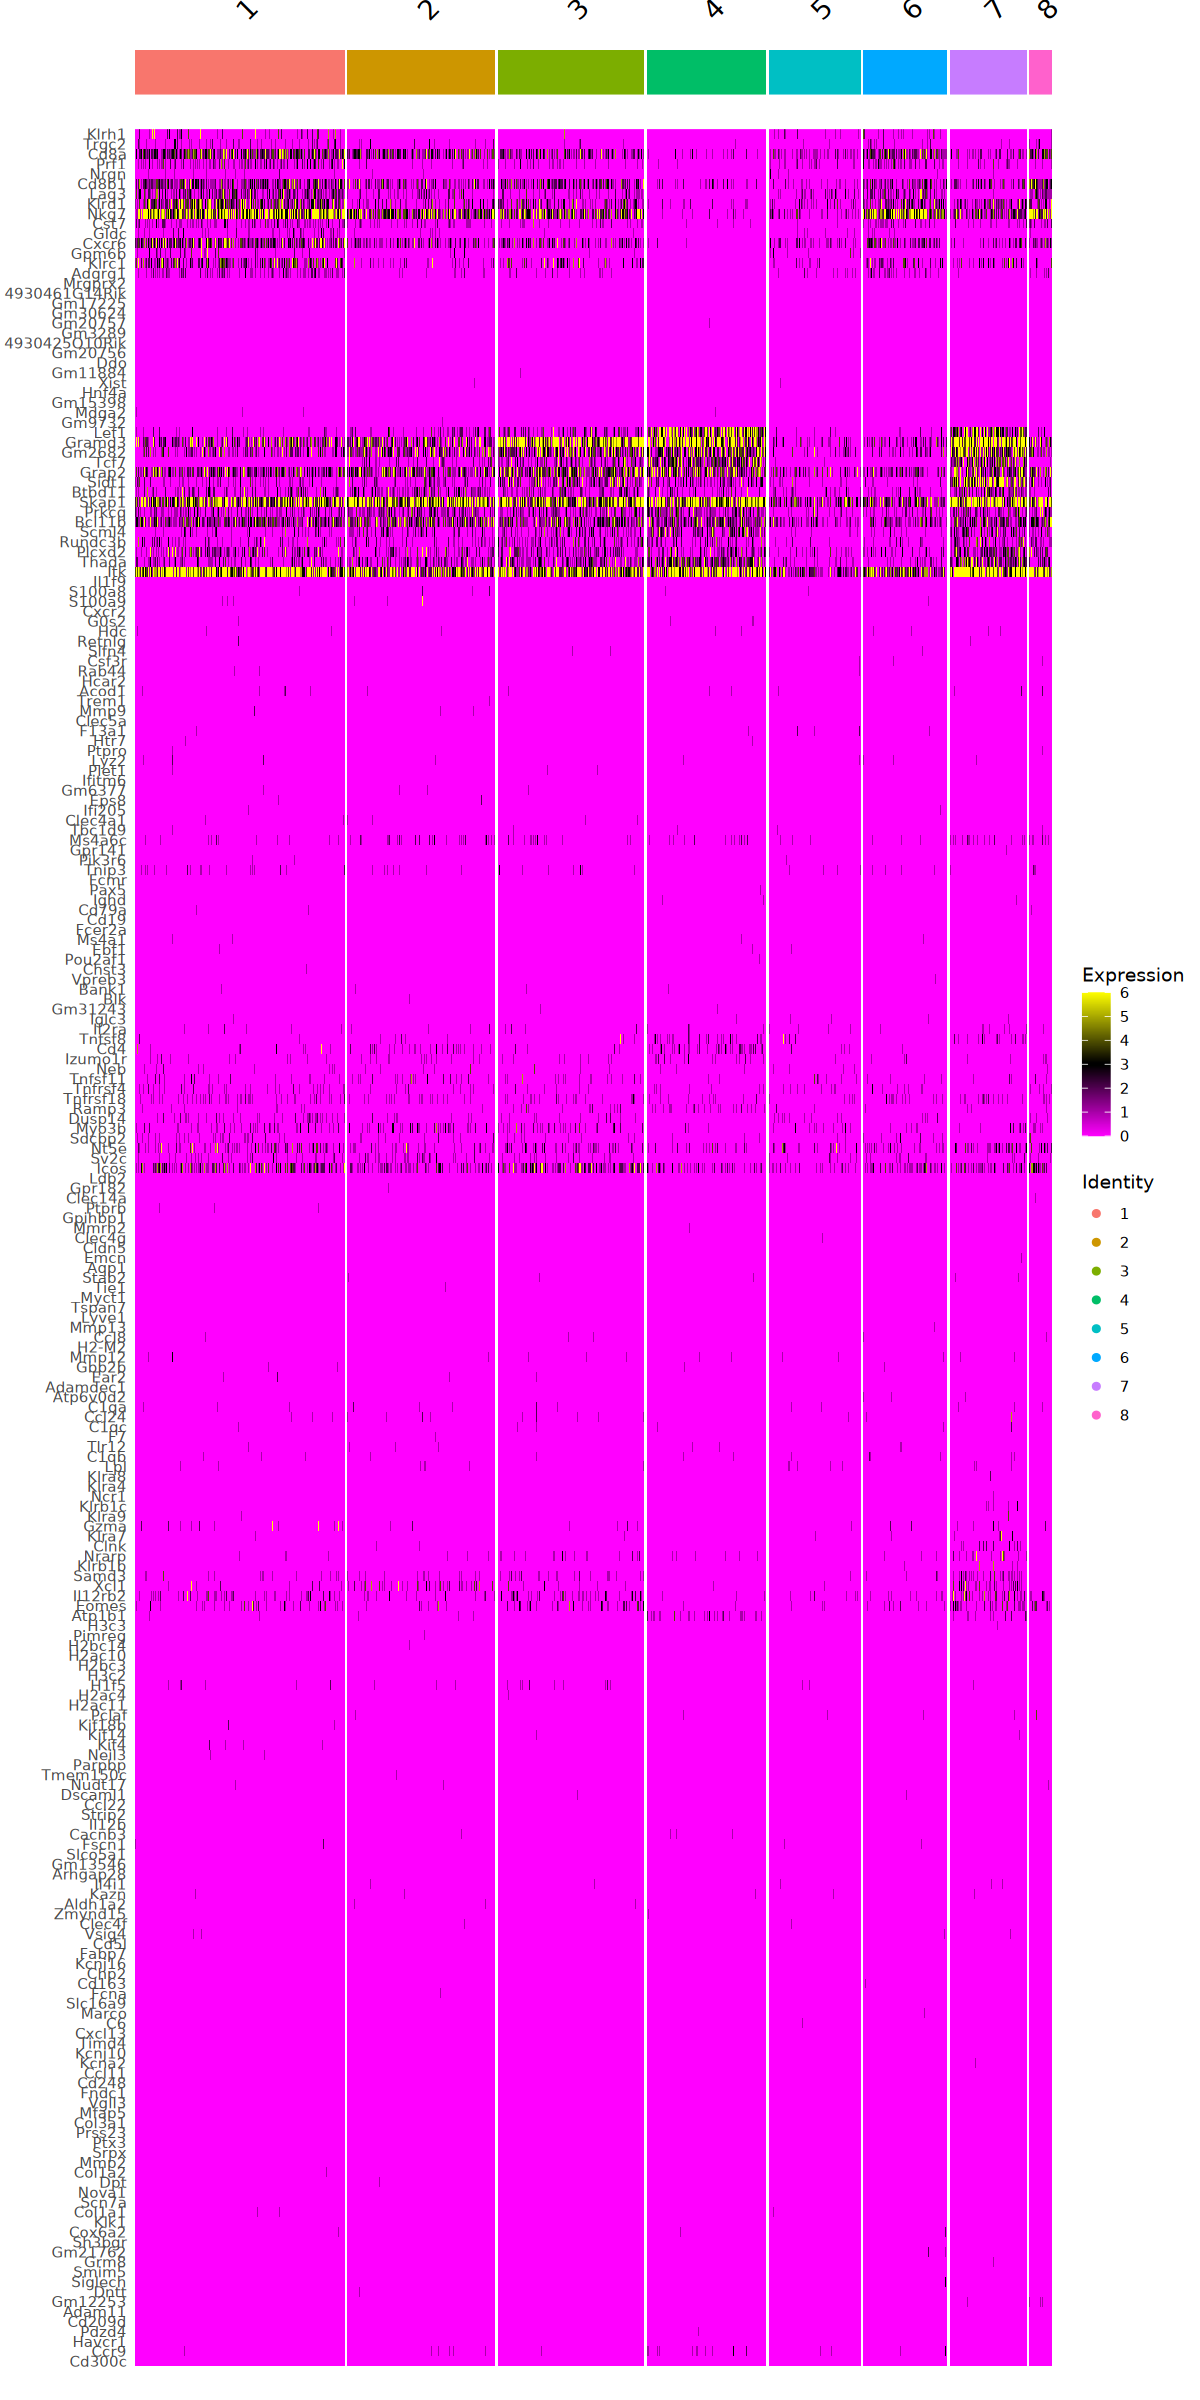

In [24]:
grp="leiden_res.0.9"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")

# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_log2FC)
options(repr.plot.width=10, repr.plot.height=20)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [25]:
barcodes<-colnames(subset(seu, doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C4

In [26]:
seu <- seu_subsets[["4"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multicore", workers = 54)
options(future.globals.maxSize = Inf)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["4"]]

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 24.073 sec elapsed


Computing nearest neighbor graph

Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only



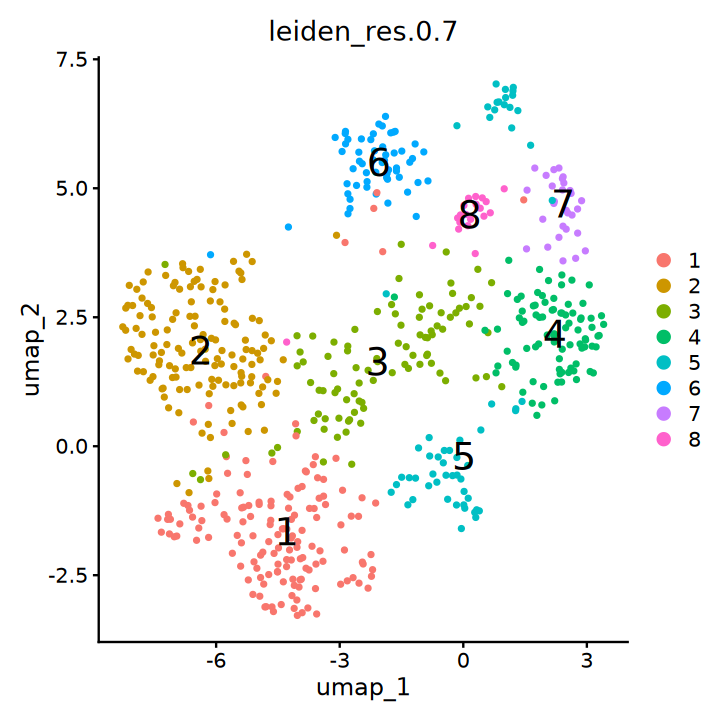

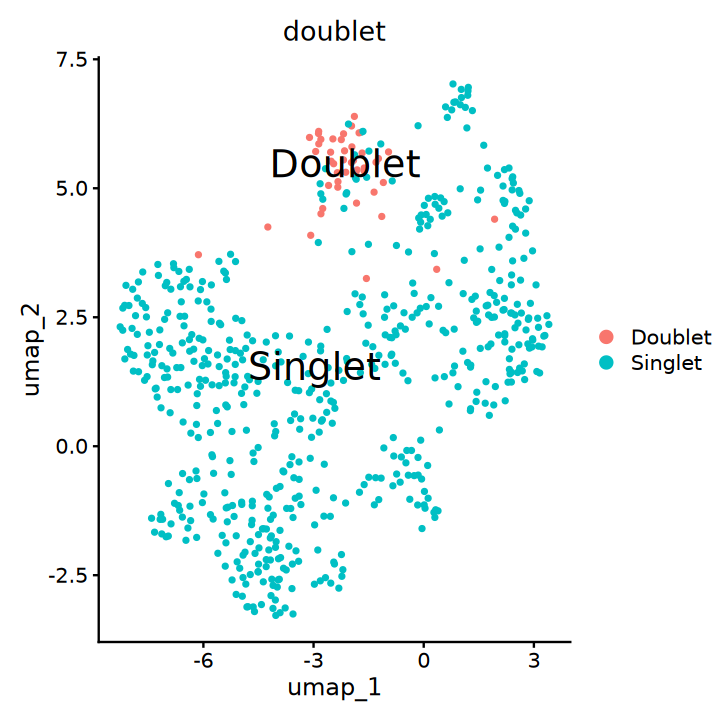

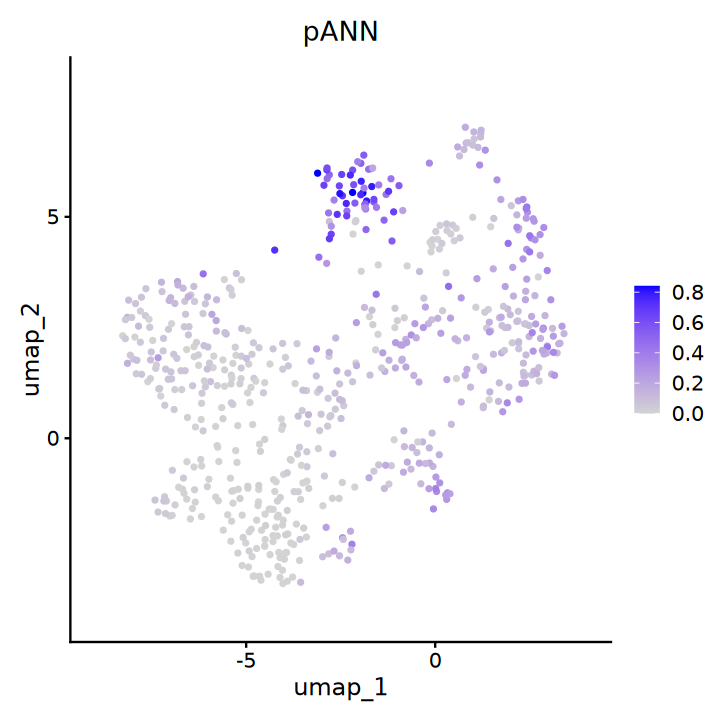

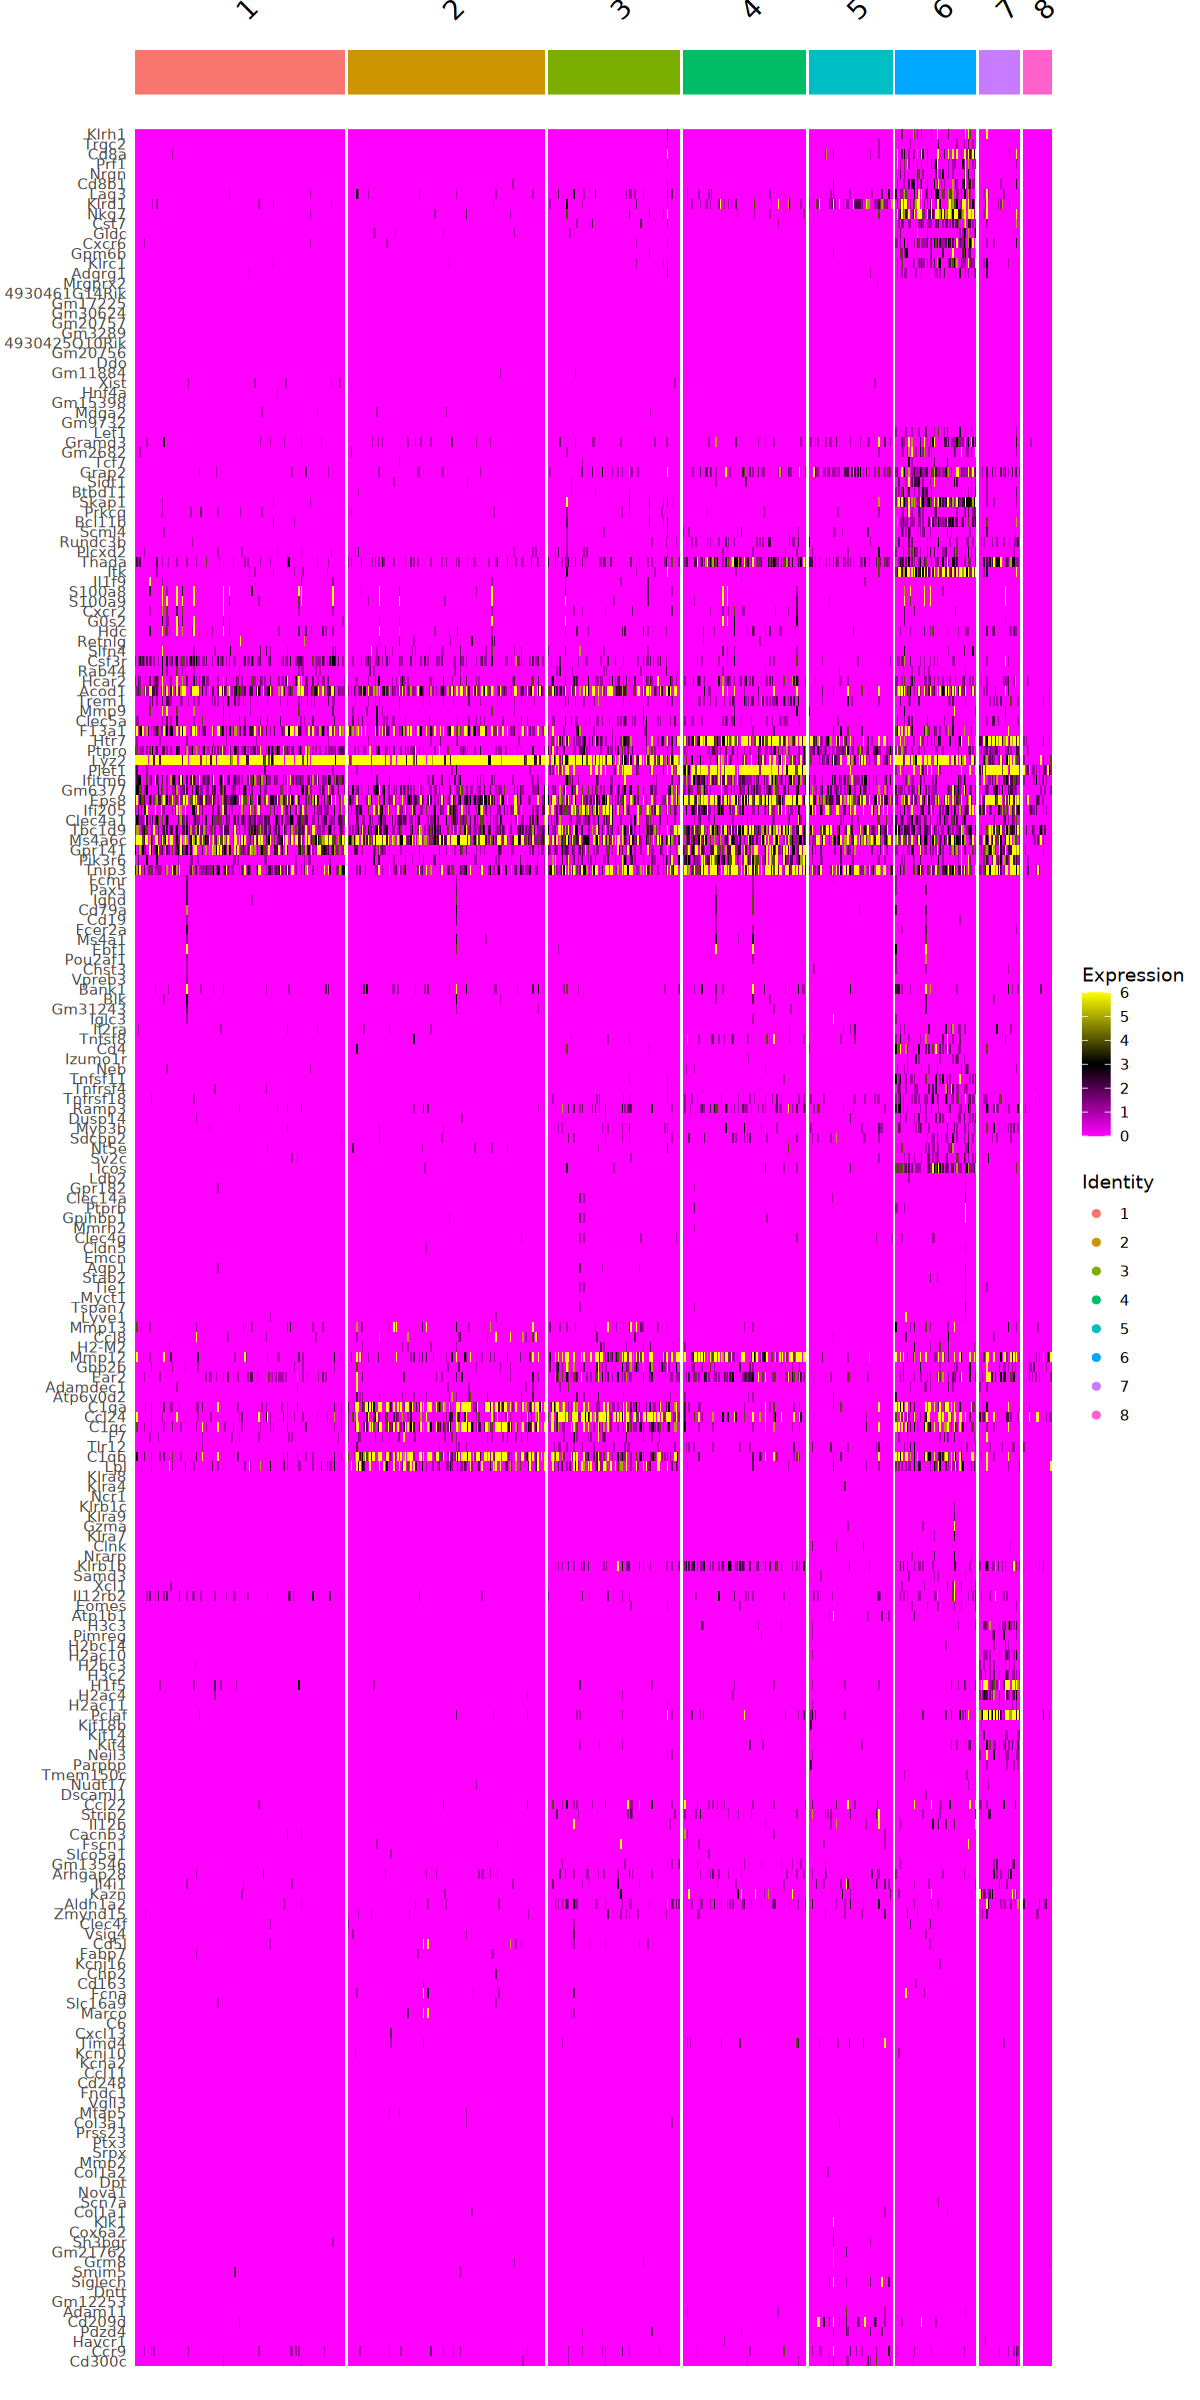

In [27]:
grp="leiden_res.0.7"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_log2FC)
options(repr.plot.width=10, repr.plot.height=20)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [28]:
barcodes<-colnames(subset(seu, leiden_res.0.7=="6"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C6

In [29]:
seu <- seu_subsets[["6"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multicore", workers = 54)
options(future.globals.maxSize = Inf)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["6"]]

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 26.938 sec elapsed


Computing nearest neighbor graph

Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only



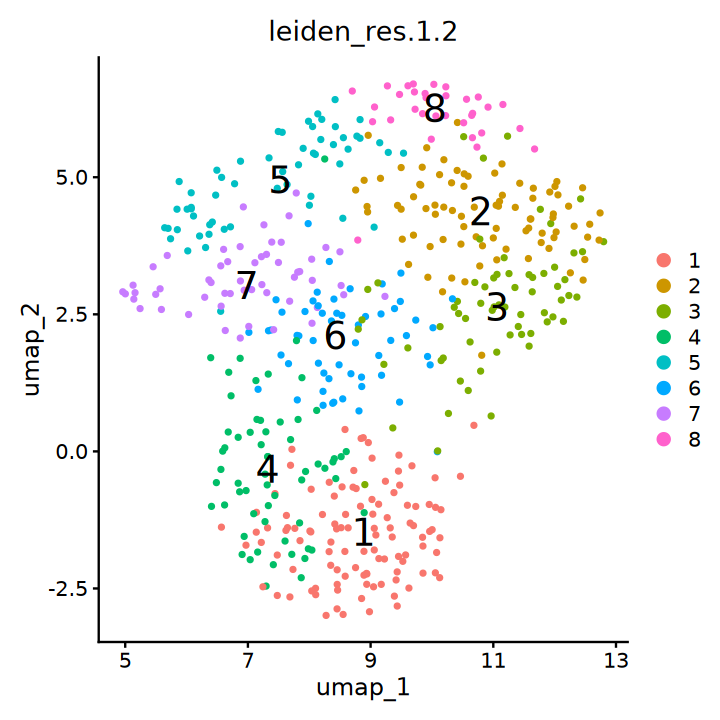

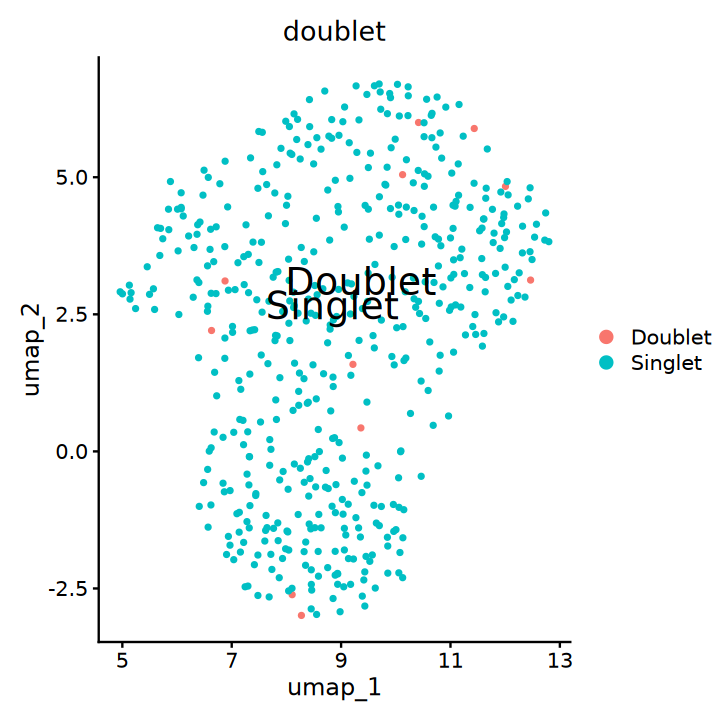

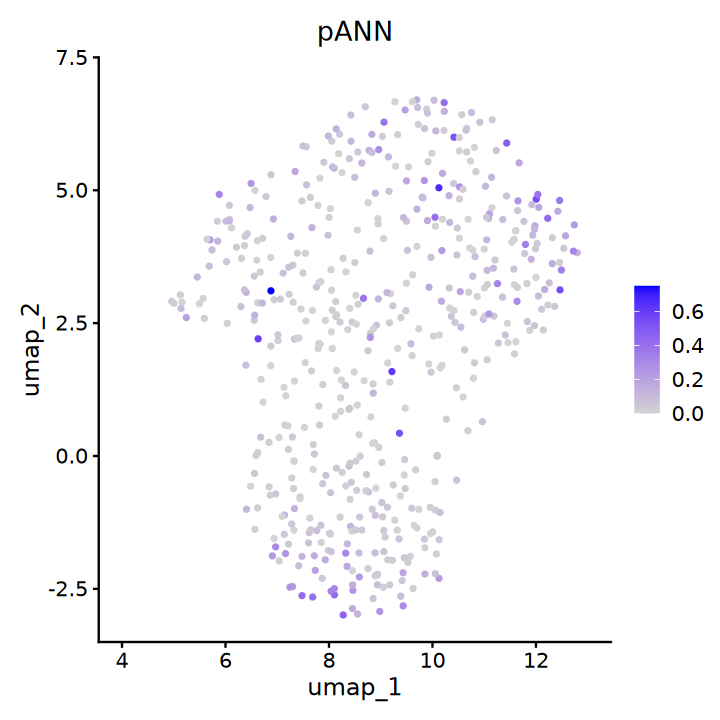

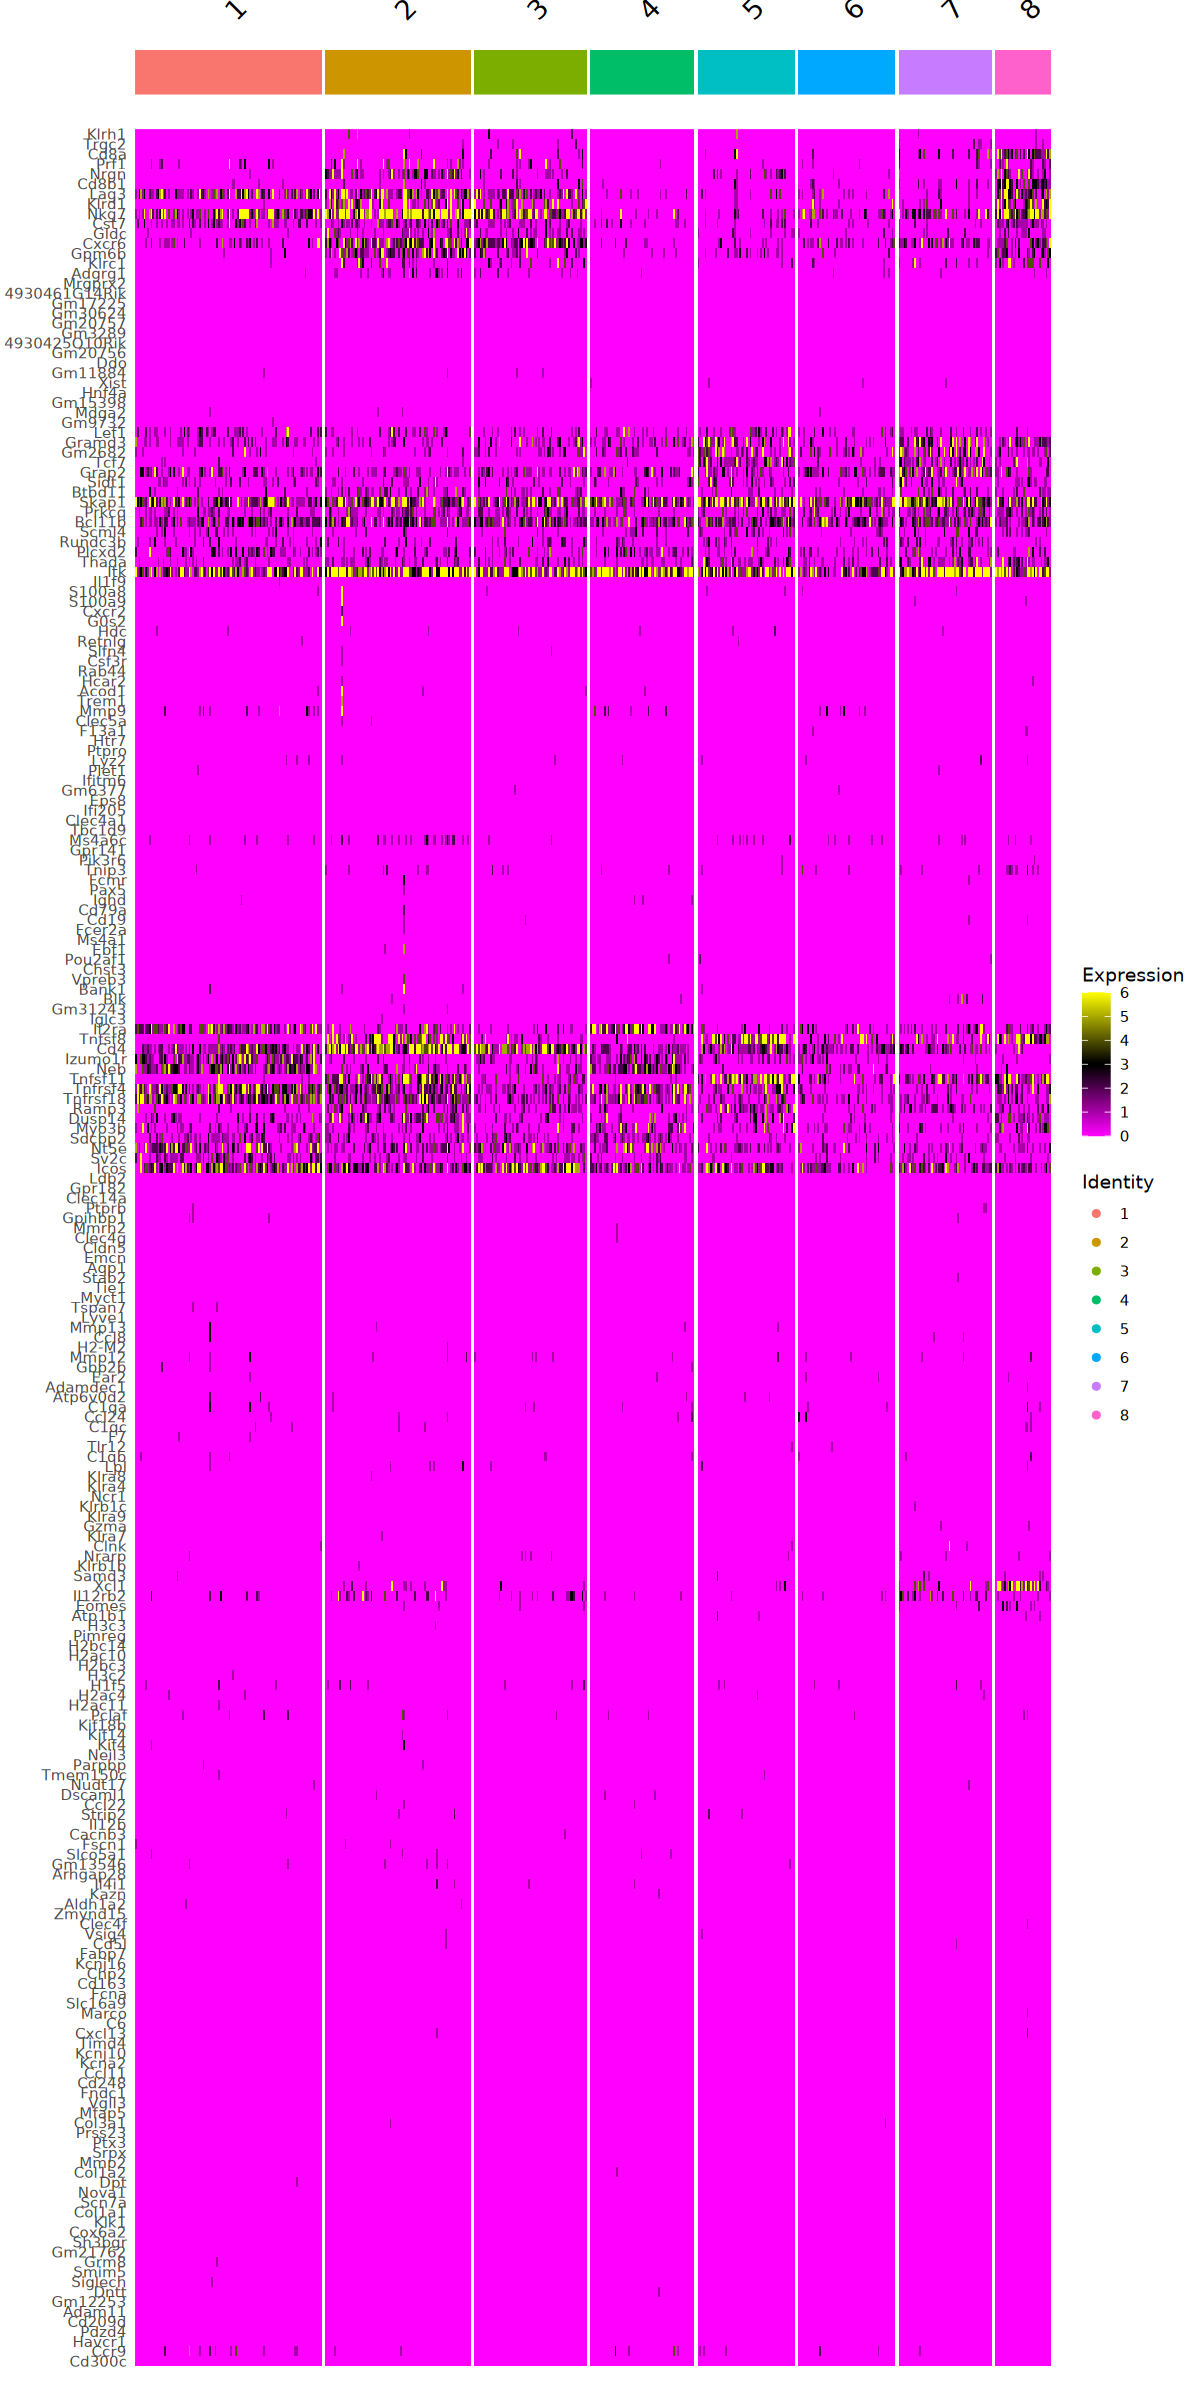

In [30]:
grp="leiden_res.1.2"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_log2FC)
options(repr.plot.width=10, repr.plot.height=20)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [31]:
barcodes<-colnames(subset(seu, doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C8

In [32]:
seu <- seu_subsets[["8"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multicore", workers = 54)
options(future.globals.maxSize = Inf)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["8"]]

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 16.606 sec elapsed


Computing nearest neighbor graph

Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only



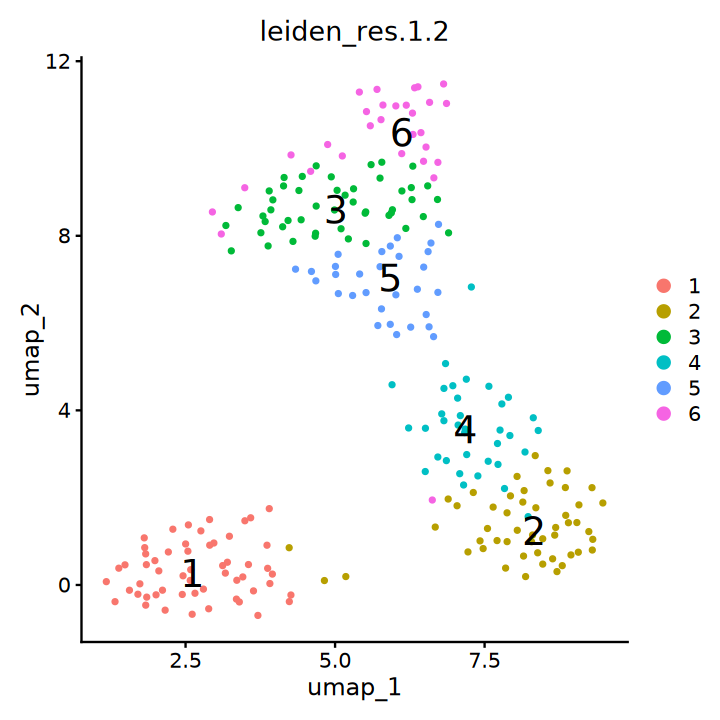

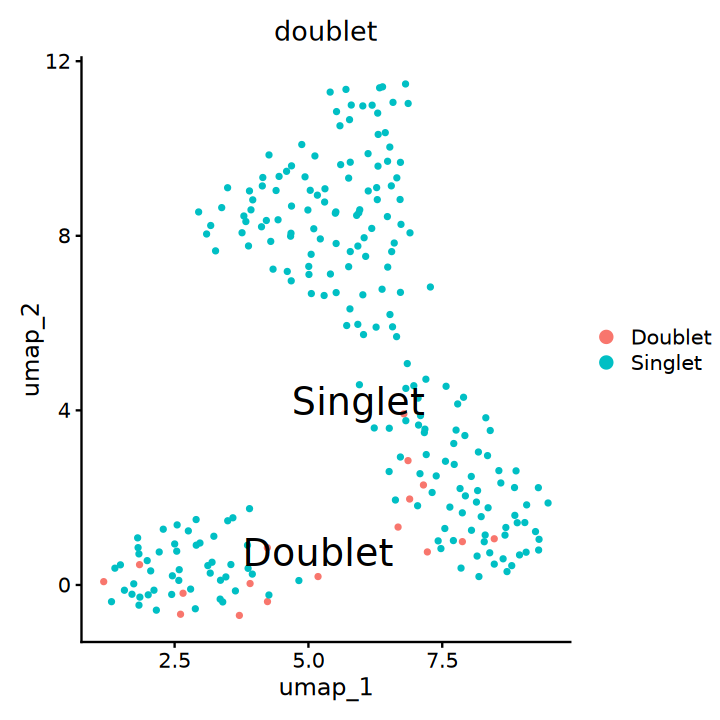

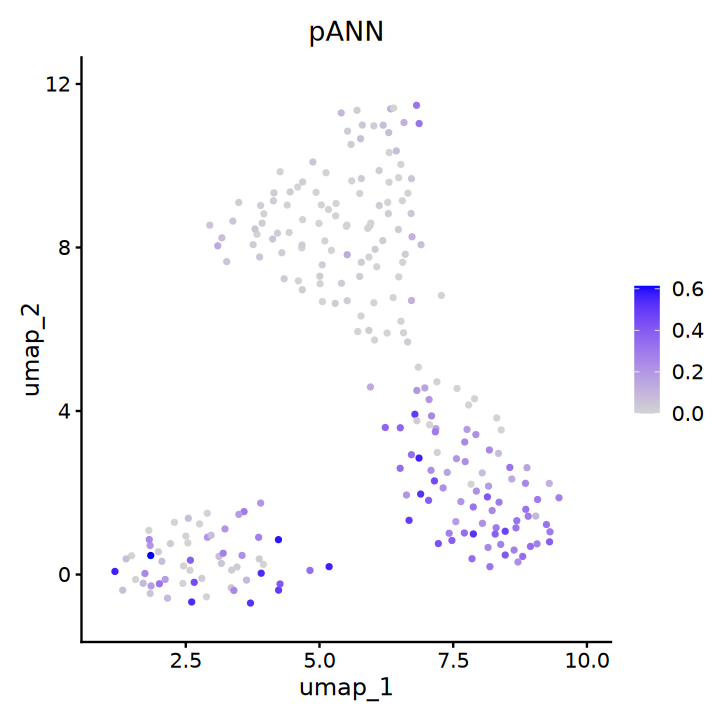

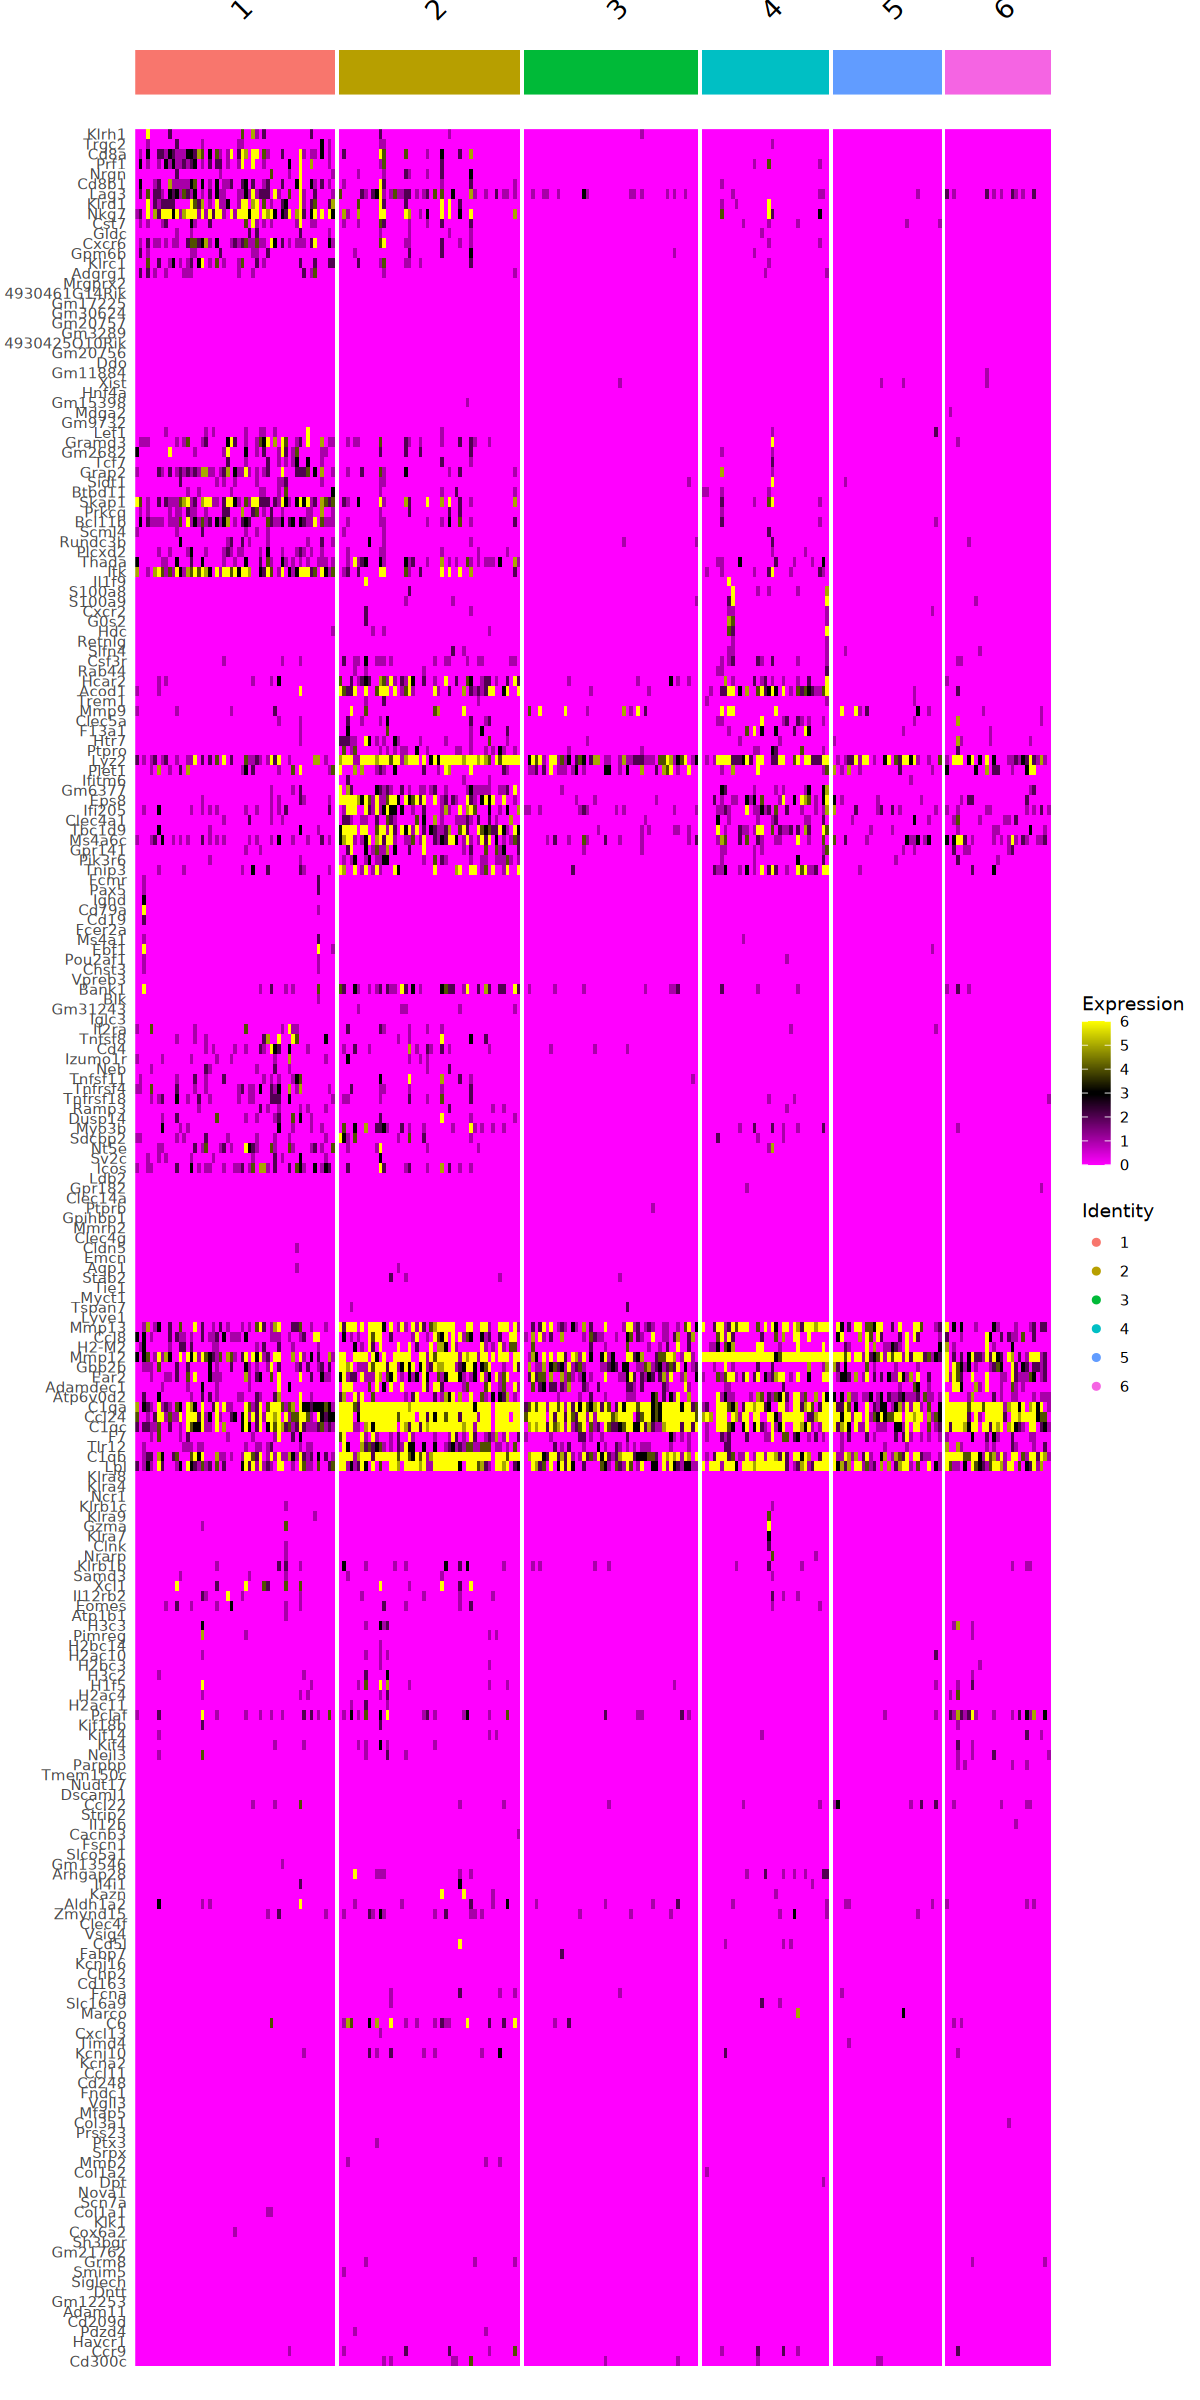

In [33]:
grp="leiden_res.1.2"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_log2FC)
options(repr.plot.width=10, repr.plot.height=20)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [34]:
barcodes<-colnames(subset(seu, doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C10

In [35]:
seu <- seu_subsets[["10"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multicore", workers = 54)
options(future.globals.maxSize = Inf)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["10"]]

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix



Renormalization and Dimensionality reduction: 15.625 sec elapsed


Computing nearest neighbor graph

Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only



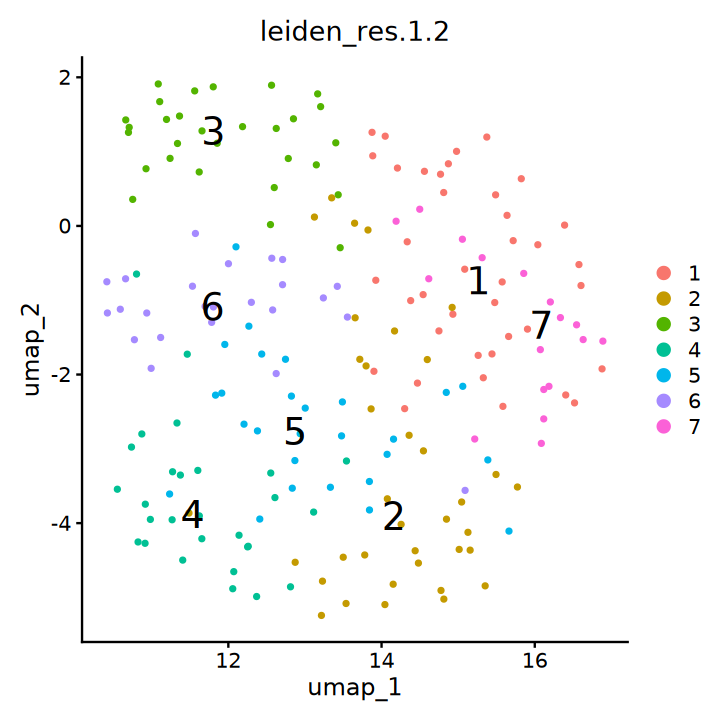

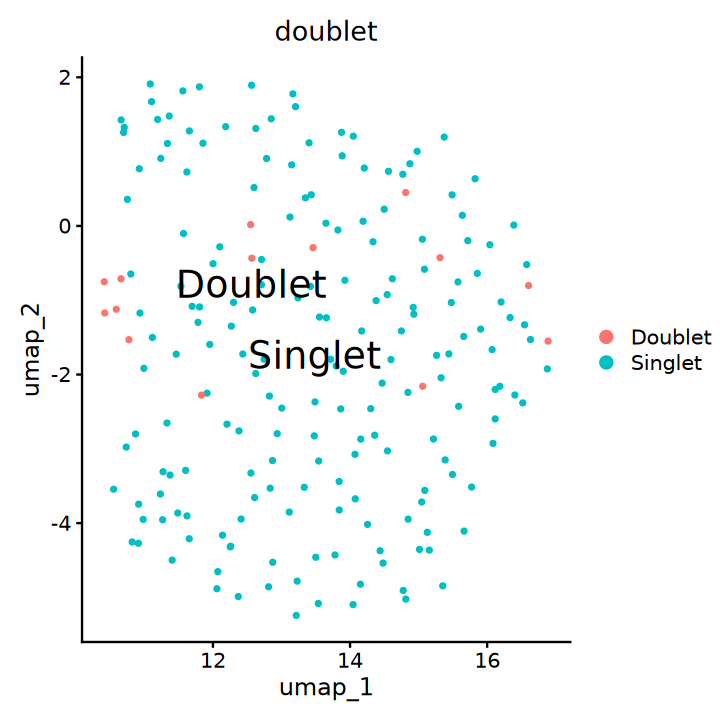

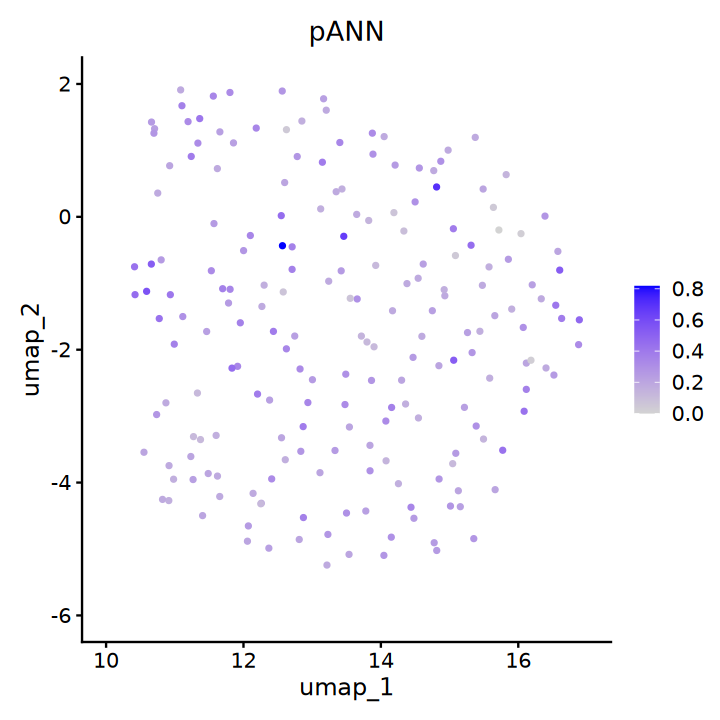

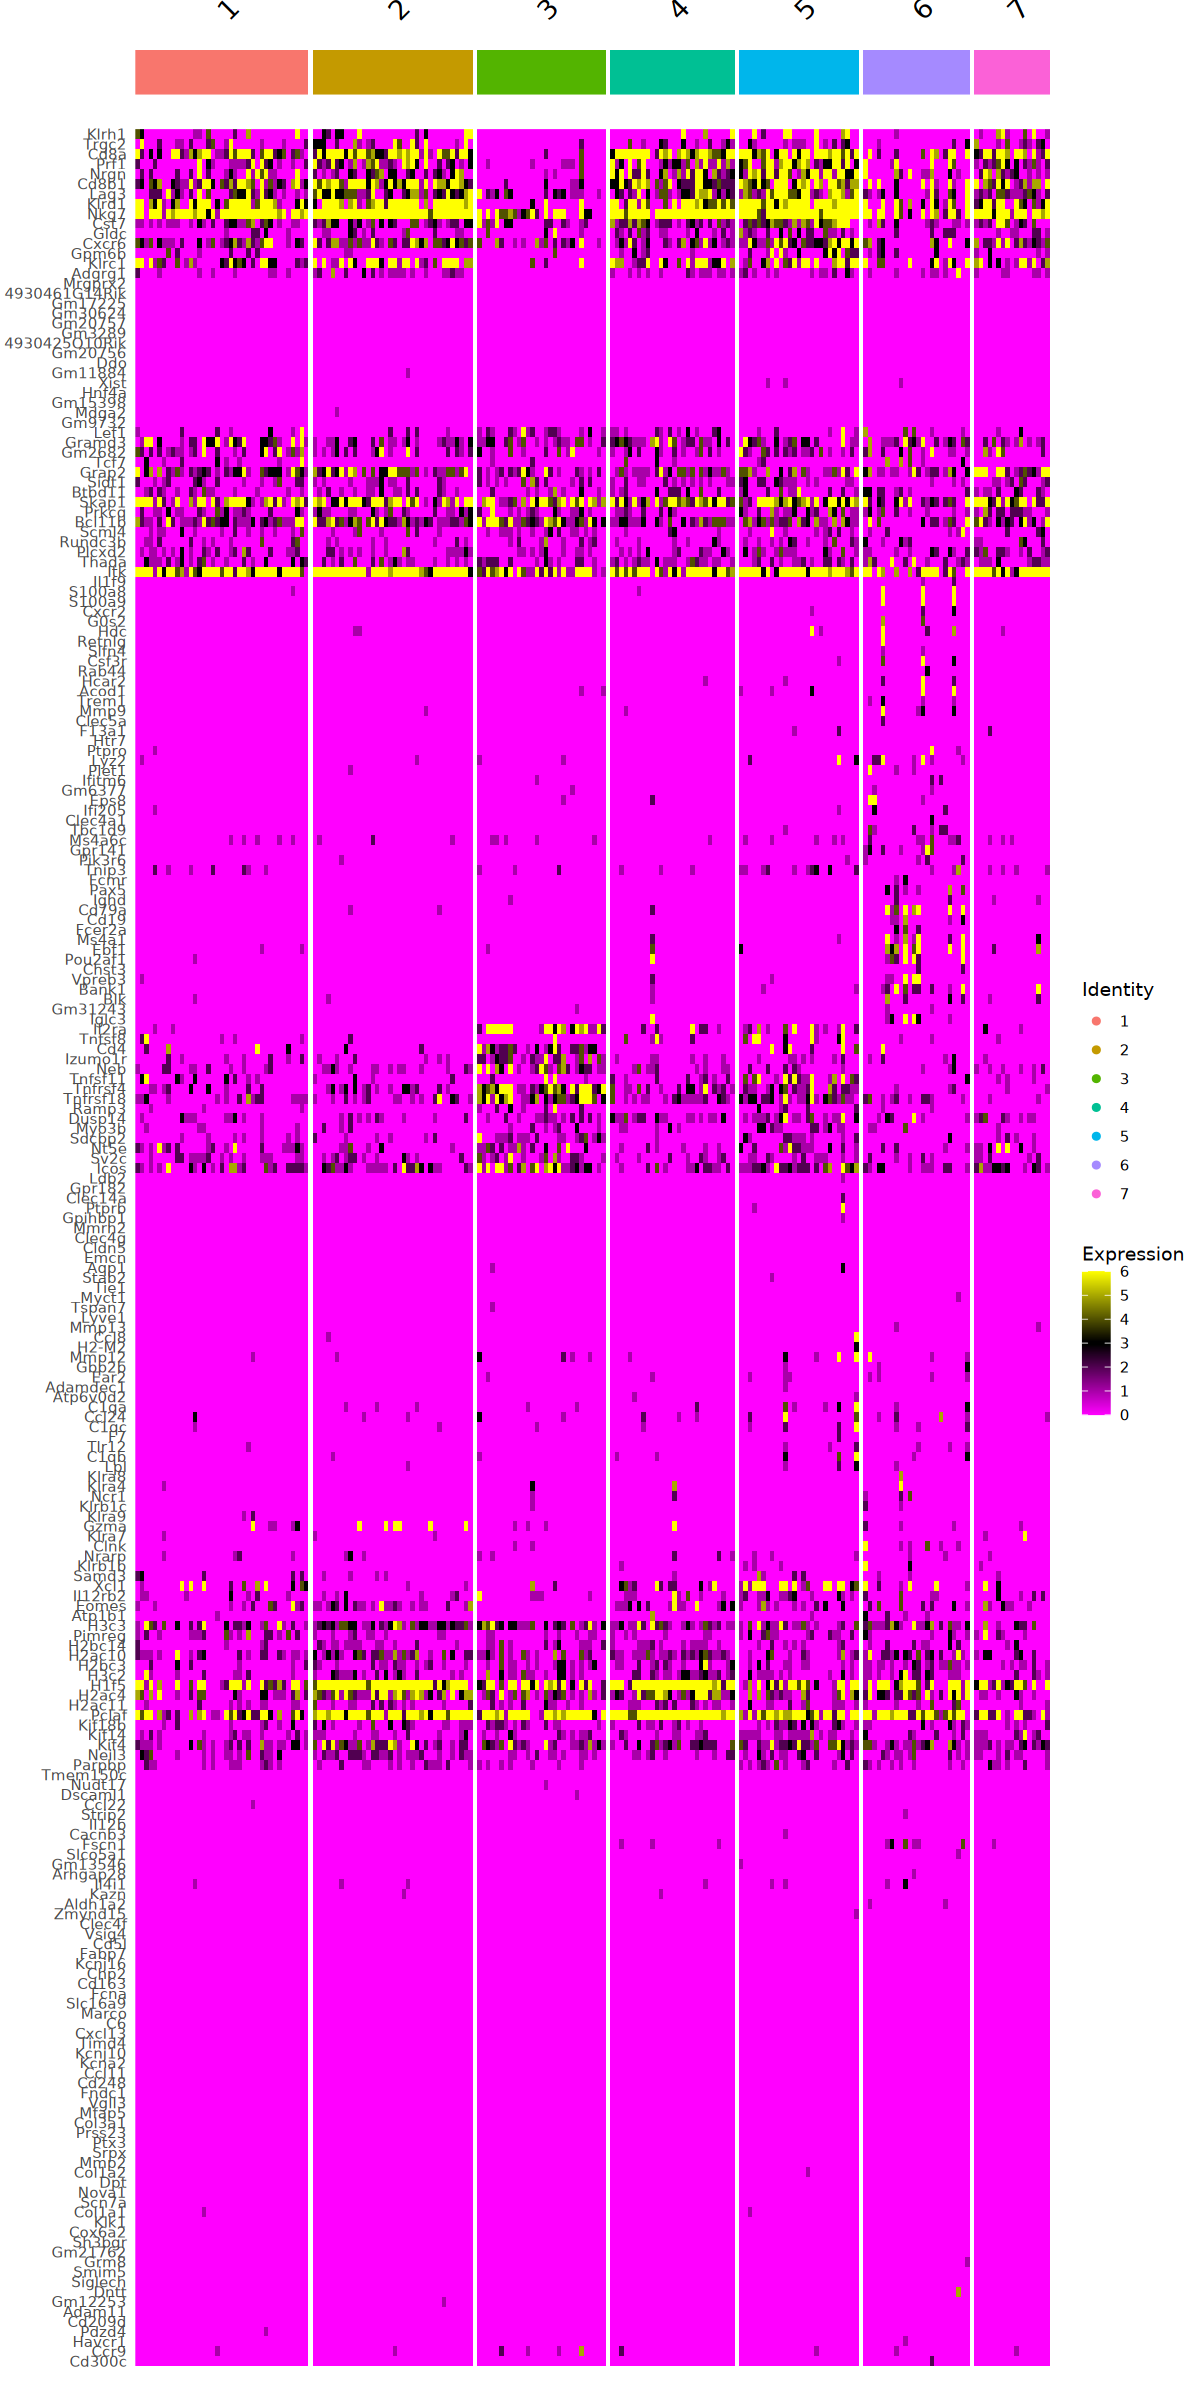

In [36]:
grp="leiden_res.1.2"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_log2FC)
options(repr.plot.width=10, repr.plot.height=20)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [37]:
barcodes<-colnames(subset(seu, leiden_res.1.2=="6"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

# C11

In [38]:
seu <- seu_subsets[["11"]]

tic("Renormalization and Dimensionality reduction")
seu  <- NormalizeData(seu,  normalization.method="LogNormalize", scale.factor=10000, block.size=800)
seu  <- FindVariableFeatures(seu,  selection.method = "vst", nfeatures = 2000)

plan("multicore", workers = 54)
options(future.globals.maxSize = Inf)
seu <- ScaleData(seu,  features=rownames(seu), block.size = 500, min.cells.to.block = 1000)
plan("sequential")

seu <- RunPCA(seu,  npcs=30, features=VariableFeatures(object=seu),  verbose = FALSE)
seu <- RunUMAP(object=seu,  dims=1:30, verbose=FALSE, min.dist=0.5, n.neighbors = 30L, umap.method = "umap-learn", metric = "correlation")
toc()

seu <- FindNeighbors(seu, dims = 1:10, graph.name = 'leiden')
seu <- FindClusters(seu, resolution = c(0.1,0.3,0.5,0.7,0.9,1.2), algorithm=4, n.iter=100, group.singletons=T,graph.name = 'leiden')


seu -> seu_subsets[["11"]]

Normalizing layer: counts

Finding variable features for layer counts

Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“pseudoinverse used at -1.4914”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“neighborhood radius 0.30103”
Warning message in simpleLoess(y, x, w, span, degree = degree, parametric = parametric, :
“reciprocal condition number  2.9647e-16”
Centering and scaling data matrix



Renormalization and Dimensionality reduction: 14.262 sec elapsed


Computing nearest neighbor graph

Computing SNN

Only one graph name supplied, storing nearest-neighbor graph only

2 singletons identified. 4 final clusters.



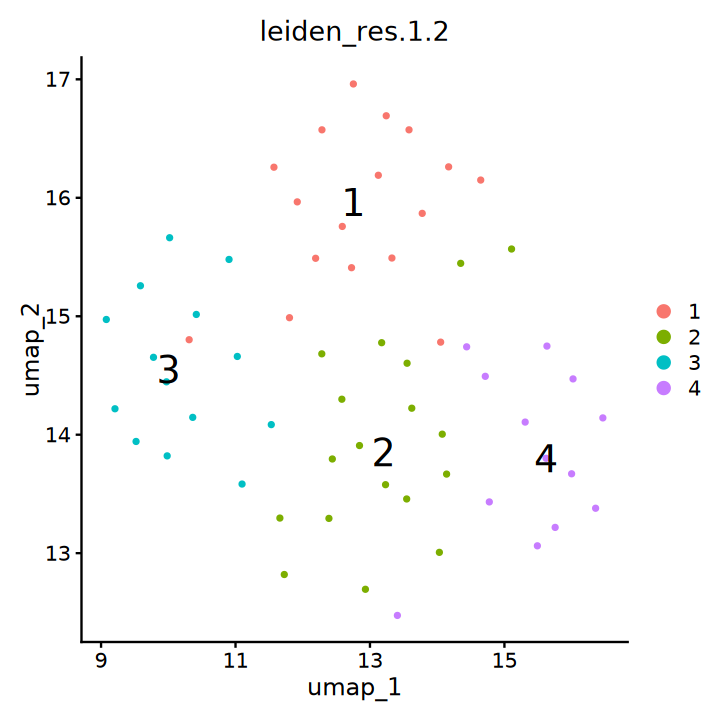

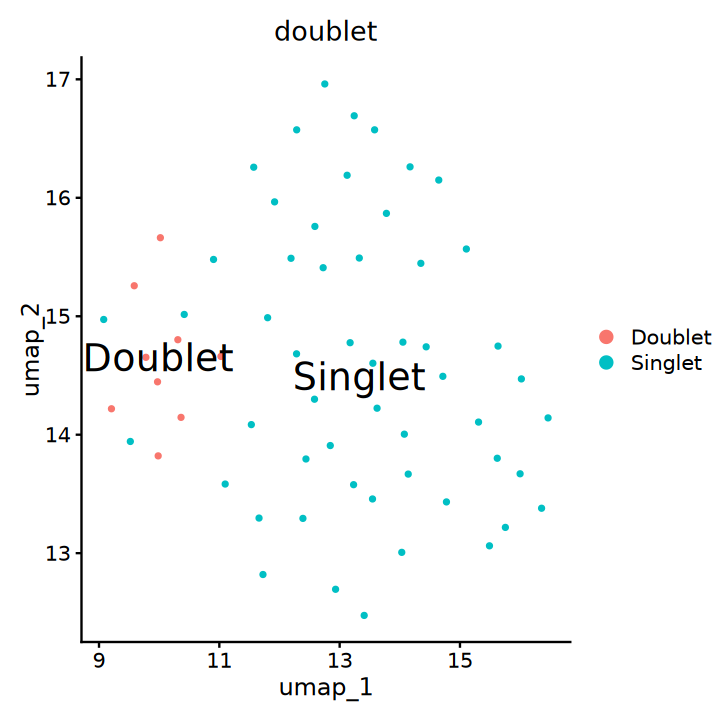

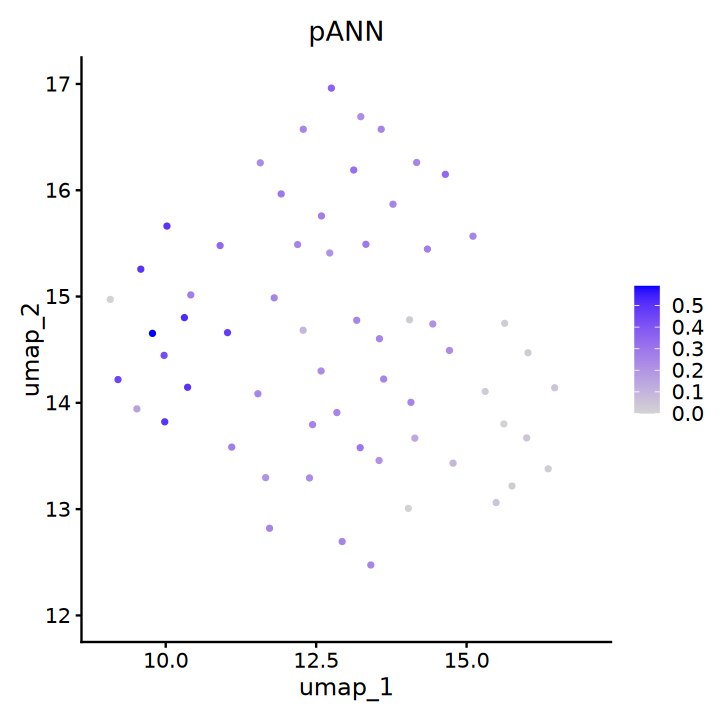

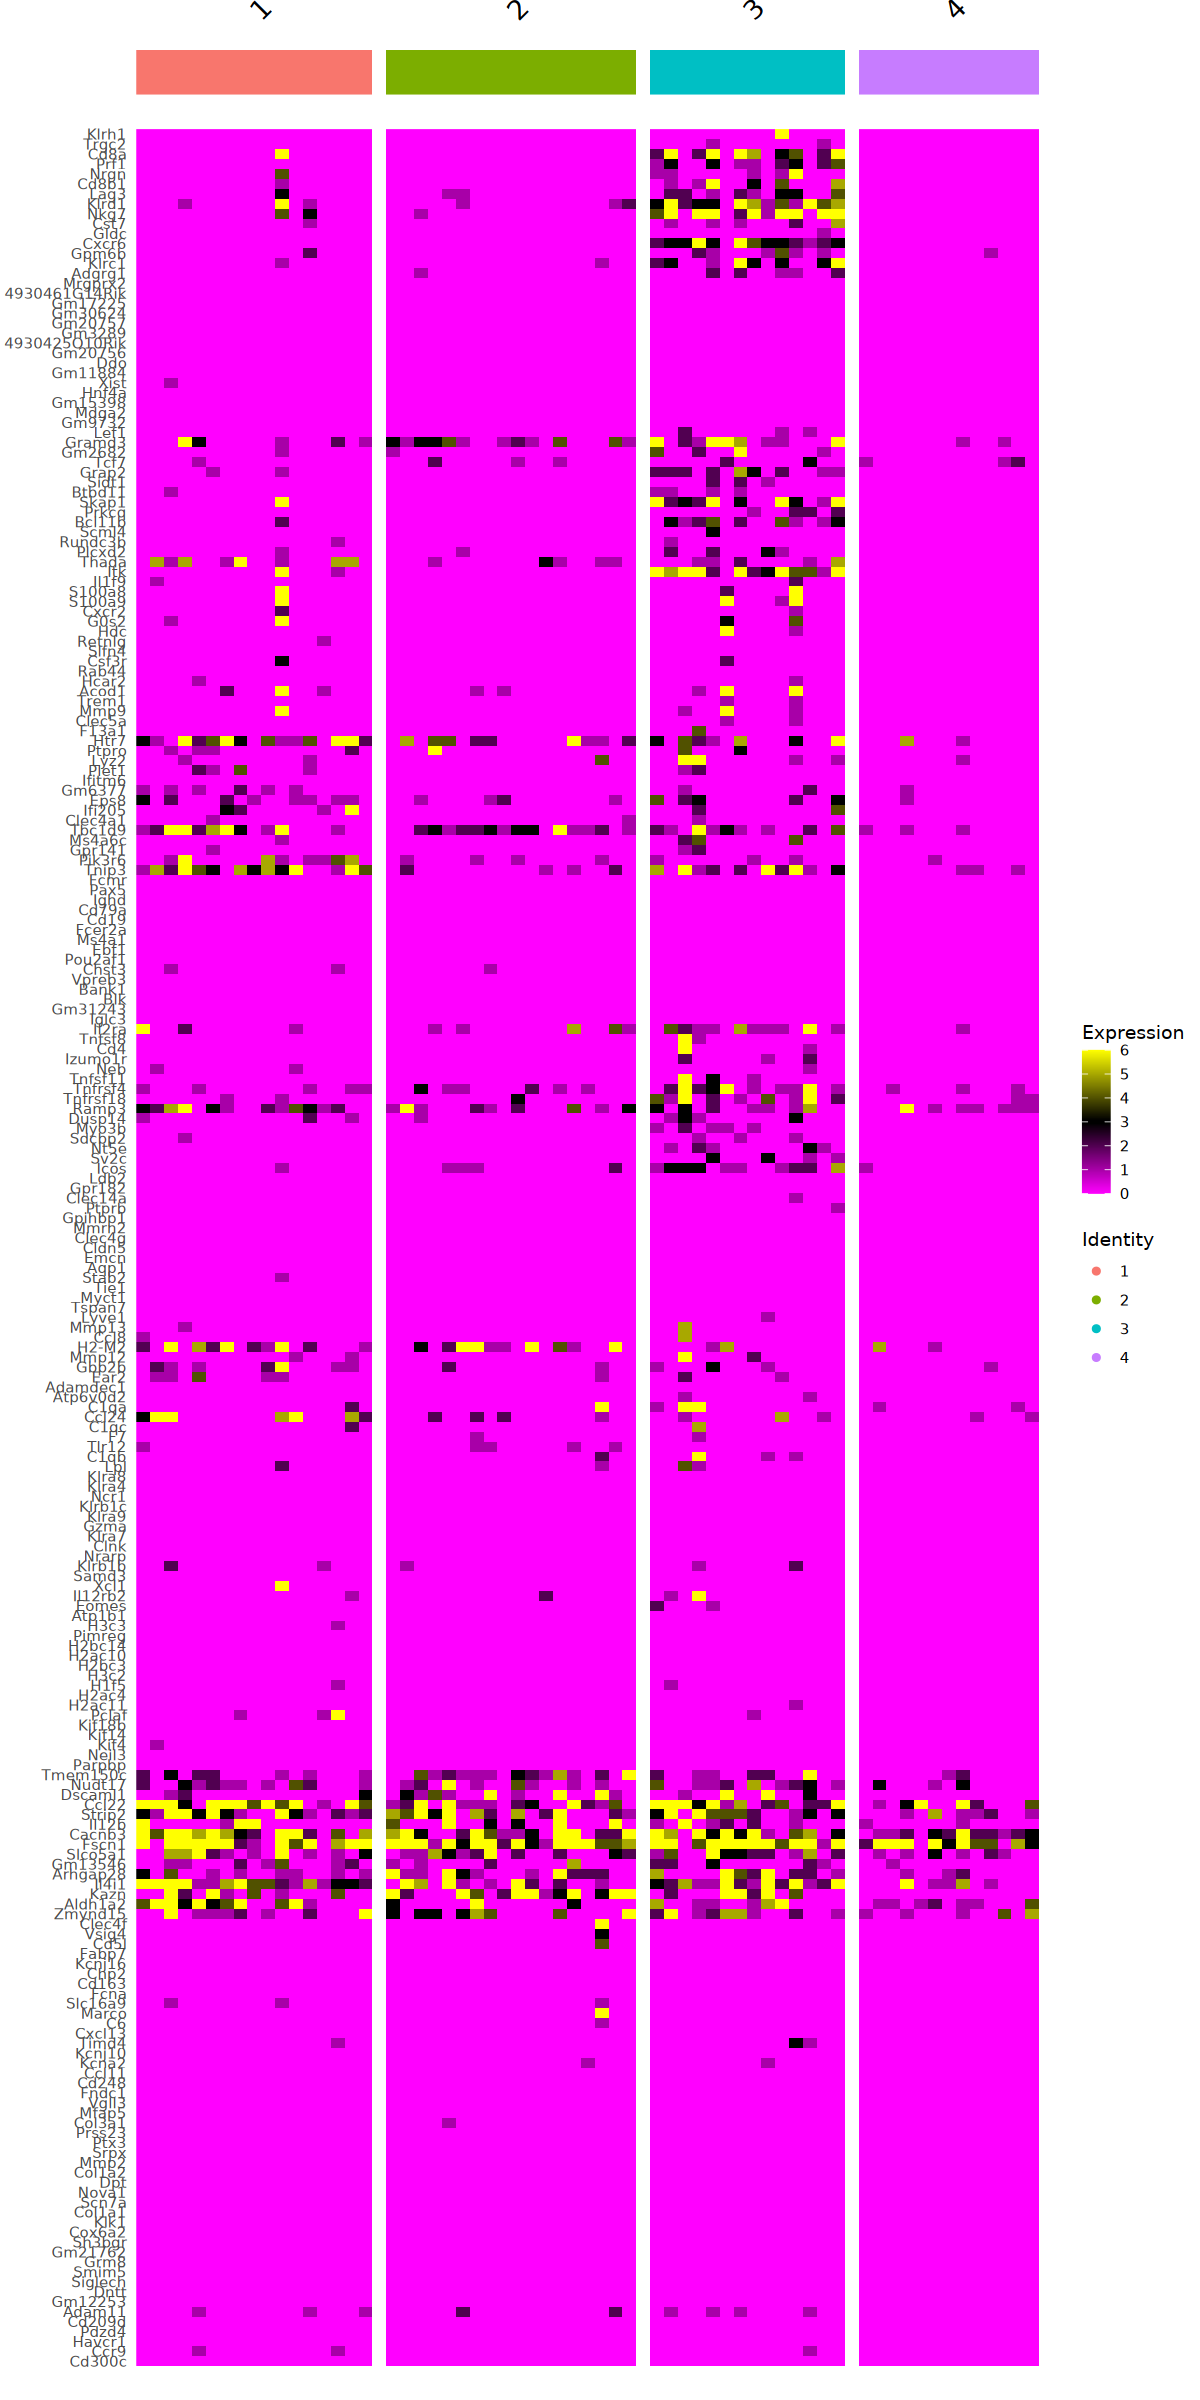

In [39]:
grp="leiden_res.1.2"

options(repr.plot.width=6, repr.plot.height=6)
DimPlot(seu, group.by=grp, label=T,label.size = 8)
DimPlot(seu, group.by="doublet", label=T,label.size = 8)
FeaturePlot(seu, features = "pANN")


# Top
markers.top  <- markers %>% group_by(cluster) %>% top_n(n = 15, wt = avg_log2FC)
options(repr.plot.width=10, repr.plot.height=20)
DoHeatmap(seu, features =markers.top$gene, slot="counts", group.by = grp )

In [40]:
barcodes<-colnames(subset(seu, leiden_res.1.2=="3"|doublet=="Doublet"))
putative_doublets<-unique(c(putative_doublets, barcodes))

In [41]:
length(putative_doublets)/ncol(seu.all)

[1] 0.09054115

In [42]:
save(putative_doublets,file = "/data3/Group8/gonglihao/1-MMP9/1-QC/shmmp9-1(multiplets).rda", compress=T)